In [ ]:
!pip install google-cloud-bigquery-storage google-cloud-bigquery db-dtypes pandas matplotlib seaborn

## Necessary Imports

Importing the necessary modules from the `google.cloud` library to interact
with [BigQuery](https://cloud.google.com/bigquery/docs/introduction).
It imports the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">bigquery</code> module and the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">Client</code> class from <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">google.cloud.bigquery</code>.
These imports are essential for establishing a connection with [BigQuery](https://cloud.google.com/bigquery/docs/introduction),
executing queries, and managing datasets within [Google Cloud Platform](https://cloud.google.com/).

<b style="color:#e83e8c">Note:</b> to install the necessary modules from the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">google.cloud</code> library, execute the command <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">pip install google-cloud-bigquery</code>

In [36]:
from __future__ import annotations

from datetime import datetime, timedelta

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import google
from google.cloud import bigquery
from google.cloud.bigquery import Client

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

from scipy.signal import argrelextrema
from scipy.signal import find_peaks

In [4]:
%load_ext google.cloud.bigquery

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
sns.set_theme()

In [64]:
start_date_ts = pd.Timestamp(END_DATE)
end_date_ts = pd.Timestamp.today()
pd.date_range(start_date_ts, end_date_ts, freq="D")

DatetimeIndex(['2024-02-01', '2024-02-02', '2024-02-03', '2024-02-04',
               '2024-02-05', '2024-02-06', '2024-02-07', '2024-02-08',
               '2024-02-09', '2024-02-10',
               ...
               '2024-07-27', '2024-07-28', '2024-07-29', '2024-07-30',
               '2024-07-31', '2024-08-01', '2024-08-02', '2024-08-03',
               '2024-08-04', '2024-08-05'],
              dtype='datetime64[ns]', length=187, freq='D')

In [69]:
train_table_name="bqmlforecast.training_data"
max_date_query = f"SELECT MAX(date) FROM `{train_table_name}`"


I0000 00:00:1722880925.503491  271409 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


datetime.date(2024, 2, 1)

In [74]:
def date_offset(n: int, freq: str) -> pd.DateOffset:
    """Generate a pandas DateOffset based on the given frequency and value.

    Parameters
    ----------
    n : int
        The number of time units for the offset.
    freq : str {'days', 'weeks', 'months', 'years'}
        The frequency type. Valid options are 'days', 'weeks', 'months', 'years'.

    Returns
    -------
    pd.DateOffset
        A DateOffset object for the specified frequency and value.

    Raises
    ------
    ValueError
        If `freq` is not one of the valid options.
    """
    if freq == "days":
        return pd.DateOffset(days=n)
    if freq == "weeks":
        return pd.DateOffset(weeks=n)
    if freq == "months":
        return pd.DateOffset(months=n)
    if freq == "years":
        return pd.DateOffset(years=n)
    raise ValueError(
        f"The specified `freq` {freq} is not a valid frequency. "
        "Valid frequencies are: 'days', 'weeks', 'months', 'years'."
    )


def get_data(
    client: google.cloud.bigquery.Client,
    table_name: str = 'bqmlforecast.training_data',
    start_date: str | None = None,
    end_date: str | None = None,
    offset: int | None = None,
    freq: str = "years",
) -> pd.DataFrame:
    """
    Retrieve data from BigQuery and create a training data view.

    This function constructs an SQL query to create a view in BigQuery,
    filters sales data based on the specified date range and conditions,
    and retrieves the filtered data as a pandas DataFrame.

    Parameters
    ----------
    client : google.cloud.bigquery.Client
        BigQuery client object.
    table_name : str, optional
        The name of the table to store the training data view.
        Default is 'bqmlforecast.training_data'.
    start_date : str, optional
        The start date for filtering data in 'YYYY-MM-DD' format.
    end_date : str, optional
        The end date for filtering data in 'YYYY-MM-DD' format.
    offset : int, optional
        The offset value to calculate the start or end date.
    freq : str, optional
        The frequency type for the offset calculation.
        Default is 'years'.

    Returns
    -------
    pd.DataFrame
        A `pandas.DataFrame` containing the filtered sales data.

    Raises
    ------
    ValueError
        If none of `start_date`, `end_date`, or `offset` are specified.
        If `start_date` > `end_date`.
    """
    if not any([start_date, end_date, offset]):
        raise ValueError(
            "At least one of the following parameters must be specified: "
            "`start_date`, `end_date` and `offset`."
        )

    if end_date is None:
        if offset is None:
            end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
        else:
            end_date = (
                (pd.Timestamp(start_date) + date_offset(offset, freq))
                .strftime("%Y-%m-%d")
            )

    elif start_date is None:
        if offset is None:
            raise ValueError(
                "If start_date is None, then `offset` and "
                "`end_date` must be specified."
            )
        start_date = (
            (pd.Timestamp(end_date) - date_offset(offset, freq))
            .strftime("%Y-%m-%d")
        )

    start_date_ts = pd.Timestamp(start_date)
    end_date_ts = pd.Timestamp(end_date)

    start_date = start_date_ts.strftime("%Y-%m-%d")
    end_date = end_date_ts.strftime("%Y-%m-%d")

    offset_start_date = (start_date_ts - pd.DateOffset(days=60)).strftime("%Y-%m-%d")
    year_count = len(pd.date_range(start_date, end_date, freq="Y"))

    if start_date_ts > end_date_ts:
        raise ValueError(f"`start_date` > `end_date`: {start_date} > {end_date}")

    query = f"""
    CREATE OR REPLACE TABLE `{table_name}` AS
    (
    WITH sales_data AS (
        SELECT
            date,
            item_description AS item_name,
            SUM(bottles_sold) AS total_amount_sold,
            AVG(state_bottle_retail) AS avg_bottle_price,
            SUM(volume_sold_liters) AS total_volume_sold_liters,
            SUM(sale_dollars) AS total_sale_dollars,
            AVG(state_bottle_retail - state_bottle_cost) AS avg_bottle_profit
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales`
        WHERE
            bottles_sold > 0
            AND sale_dollars > 0
            AND city IS NOT NULL
        GROUP BY
            date, item_name
        HAVING
            date >= DATE('{offset_start_date}')
    ),
    filtered_sales AS (
        SELECT
            sd.date,
            sd.item_name,
            sd.total_amount_sold,
            sd.avg_bottle_price,
            sd.total_volume_sold_liters,
            sd.total_sale_dollars,
            sd.avg_bottle_profit
        FROM
            sales_data AS sd
        INNER JOIN
            (
                SELECT
                    d2.item_name
                FROM
                    (
                        SELECT
                            sd.item_name,
                            EXTRACT(YEAR FROM date) AS year
                        FROM
                            sales_data AS sd
                        WHERE
                            sd.date BETWEEN DATE('{start_date}') AND DATE('{end_date}')
                        GROUP BY
                            year, sd.item_name 
                        HAVING
                            SUM(sd.total_amount_sold) > 100  -- Adjust the threshold as needed
                            AND COUNT(DISTINCT sd.date) > 180
                    ) AS d2
                GROUP BY
                    d2.item_name
                HAVING
                    COUNT(DISTINCT d2.year) >= {year_count - 1}
            ) AS d3
        ON
            sd.item_name = d3.item_name
        INNER JOIN
            (
                SELECT
                    d4.item_name,
                    MAX(EXTRACT(YEAR FROM date)) AS max_year
                FROM
                    sales_data AS d4
                GROUP BY
                    d4.item_name 
                HAVING
                    max_year = {end_date_ts.year}
            ) AS d5
        ON
            sd.item_name = d5.item_name
    )
    SELECT
        date,
        item_name,
        total_amount_sold,
        avg_bottle_price,
        total_volume_sold_liters,
        total_sale_dollars,
        avg_bottle_profit,
        EXTRACT(DAYOFWEEK FROM date) AS day_of_week,
        EXTRACT(WEEK FROM date) AS week_of_year,
        EXTRACT(MONTH FROM date) AS month,
        EXTRACT(YEAR FROM date) AS year,
        -- 7-day moving averages
        AVG(total_amount_sold) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_amount_sold,
        AVG(avg_bottle_price) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_avg_bottle_price,
        AVG(total_sale_dollars) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_sale_dollars,
        -- 30-day moving averages
        AVG(total_amount_sold) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_amount_sold,
        AVG(avg_bottle_price) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_avg_bottle_price,
        AVG(total_sale_dollars) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_sale_dollars,
    FROM
        filtered_sales
    WHERE
        date BETWEEN DATE('{start_date}') AND DATE('{end_date}')
    ORDER BY
        item_name, date
    )
    """
    query_job = client.query(query)
    print(query_job.result())

    return client.query(f"SELECT * FROM `{table_name}`").to_dataframe()


def get_test_data(
    client,
    table_name="bqmlforecast.test_data",
    train_table_name="bqmlforecast.training_data",
    start_date=None,
    end_date=None,
):
    if start_date is None:
        max_date_query = f"SELECT MAX(date) FROM `{train_table_name}`"
        start_date = client.query(max_date_query).to_dataframe().values[0][0].strftime("%Y-%m-%d")

    if end_date is None:
        end_date = pd.Timestamp.today().strftime("%Y-%m-%d")

    start_date_ts = pd.Timestamp(start_date)
    end_date_ts = pd.Timestamp(end_date)

    start_date = start_date_ts.strftime("%Y-%m-%d")
    end_date = end_date_ts.strftime("%Y-%m-%d")

    offset_start_date = (start_date_ts - pd.DateOffset(days=60)).strftime("%Y-%m-%d")
    year_count = len(pd.date_range(start_date, end_date, freq="Y"))

    if start_date_ts > end_date_ts:
        raise ValueError(f"`start_date` > `end_date`: {start_date} > {end_date}")
    
    query = f"""
    CREATE OR REPLACE TABLE `{table_name}` AS
    (
    WITH sales_data AS (
        SELECT
            date,
            item_description AS item_name,
            SUM(bottles_sold) AS total_amount_sold,
            AVG(state_bottle_retail) AS avg_bottle_price,
            SUM(volume_sold_liters) AS total_volume_sold_liters,
            SUM(sale_dollars) AS total_sale_dollars,
            AVG(state_bottle_retail - state_bottle_cost) AS avg_bottle_profit
        FROM
            `bigquery-public-data.iowa_liquor_sales.sales`
        WHERE
            bottles_sold > 0
            AND sale_dollars > 0
            AND city IS NOT NULL
        GROUP BY
            date, item_name
        HAVING
            date >= DATE('{offset_start_date}')
    ),
    filtered_sales AS (
        SELECT
            sd.date,
            sd.item_name,
            sd.total_amount_sold,
            sd.avg_bottle_price,
            sd.total_volume_sold_liters,
            sd.total_sale_dollars,
            sd.avg_bottle_profit
        FROM
            sales_data AS sd
        INNER JOIN
            (
                SELECT
                    DISTINCT item_name
                FROM
                    `{train_table_name}`
            ) AS d2
        ON
            sd.item_name = d2.item_name
    )
    SELECT
        date,
        item_name,
        total_amount_sold,
        avg_bottle_price,
        total_volume_sold_liters,
        total_sale_dollars,
        avg_bottle_profit,
        EXTRACT(DAYOFWEEK FROM date) AS day_of_week,
        EXTRACT(WEEK FROM date) AS week_of_year,
        EXTRACT(MONTH FROM date) AS month,
        EXTRACT(YEAR FROM date) AS year,
        -- 7-day moving averages
        AVG(total_amount_sold) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_amount_sold,
        AVG(avg_bottle_price) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_avg_bottle_price,
        AVG(total_sale_dollars) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_sale_dollars,
        -- 30-day moving averages
        AVG(total_amount_sold) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_amount_sold,
        AVG(avg_bottle_price) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_avg_bottle_price,
        AVG(total_sale_dollars) OVER (PARTITION BY item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_sale_dollars,
    FROM
        filtered_sales
    WHERE
        date >= DATE('{start_date}') AND date <= DATE('{end_date}')
    ORDER BY
        item_name, date
    )
    """
    query_job = client.query(query)
    print(query_job.result())
    return client.query(f"SELECT * FROM `{table_name}`").to_dataframe()

In [48]:
def plot_historical_and_forecast(
    input_timeseries,
    timestamp_col_name,
    data_col_name,
    forecast_output=None,
    actual=None,
    title=None,
    plotstartdate=None,
    show_peaks=True,
    **plot_kwargs,
):

    figsize = plot_kwargs.get("figsize", (20, 6))
    plot_title = plot_kwargs.get("plot_title", True)
    title_fontsize = plot_kwargs.get("title_fontsize", 16)
    plot_legend = plot_kwargs.get("plot_legend", True)
    loc = plot_kwargs.get('loc', 'upper left')
    prop = plot_kwargs.get('prop', {'size': 14})

    if plotstartdate:
        input_timeseries[timestamp_col_name] = pd.to_datetime(input_timeseries[timestamp_col_name])
        input_timeseries = input_timeseries[input_timeseries[timestamp_col_name] >= pd.to_datetime(plotstartdate)]
        
    input_timeseries = input_timeseries.sort_values(timestamp_col_name)
    
    # Plot the input historical data
    plt.figure(figsize=figsize)
    plt.plot(input_timeseries[timestamp_col_name], input_timeseries[data_col_name], label = 'Historical')
    plt.xlabel(timestamp_col_name)
    plt.ylabel(data_col_name)

    if show_peaks:
        peaks, _ = find_peaks(input_timeseries[data_col_name], height=0)
        peak_indices = (input_timeseries.iloc[peaks][data_col_name].sort_values(ascending=False)[:9]).index
        mask = input_timeseries.index.isin(peak_indices)
        plt.scatter(x=input_timeseries[mask][timestamp_col_name], y=input_timeseries[mask][data_col_name], marker = "x", color='red')

    if forecast_output is not None:
        forecast_output = forecast_output.sort_values('forecast_timestamp')
        forecast_output['forecast_timestamp'] = pd.to_datetime(forecast_output['forecast_timestamp'])
        x_data = forecast_output['forecast_timestamp']
        y_data = forecast_output['forecast_value']
        confidence_level = forecast_output['confidence_level'].iloc[0] * 100
        low_CI = forecast_output['confidence_interval_lower_bound']
        upper_CI = forecast_output['confidence_interval_upper_bound']

        # Plot the forecast data
        plt.plot(x_data, y_data, alpha = 1, label = 'Forecast', linestyle='--')

        # Shade the confidence interval
        plt.fill_between(x_data, low_CI, upper_CI, color = '#539caf', alpha = 0.4,
                         label = f'{confidence_level} confidence interval')

    # Plot actual data
    if actual is not None:
        actual = actual.sort_values(timestamp_col_name)
        plt.plot(actual[timestamp_col_name], actual[data_col_name], label = 'Actual', linestyle='--')

    # Display title, legend
    if plot_title:
        plt.title(f'{title}', fontsize=title_fontsize)

    if plot_legend:
        plt.legend(loc=loc, prop=prop)
    plt.show()

## Initializing BigQuery Client

Creating an instance of the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">bigquery.Client</code> class with the project ID <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">"bunge-demo"</code>. This client will be used to interact with the BigQuery service within the specified Google Cloud project. 

The `Client` class from the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">google.cloud.bigquery</code> module is essential for managing and executing queries, as well as handling other BigQuery-related operations.

<b style="color:#e83e8c">Note:</b> Ensure that your Google Cloud credentials are properly set up and the project ID <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">"bunge-demo"</code> is accessible.


In [7]:
PROJECT_ID = "ee-ingwersen"
DATASET = "bqmlforecast"

client = bigquery.Client(PROJECT_ID)

In [8]:
START_DATE = "2021-01-01"
END_DATE = "2024-02-01"

OFFSET_START_DATE = (pd.Timestamp(START_DATE) - pd.DateOffset(days=31)).strftime("%Y-%m-%d")

## Creating BigQuery Dataset

Defining the dataset name and constructing a SQL query to create a new schema (dataset) in BigQuery. The dataset will be named <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">"bqmlforecast"</code> and will be created in the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">"us"</code> location.

- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">DATASET = "bqmlforecast"</code>: Sets the name of the dataset.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">dataset_create_query</code>: A formatted string containing the SQL <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">CREATE SCHEMA</code> statement to create the dataset with the specified options.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">dataset_create_job = client.query(dataset_create_query)</code>: Submits the query to create the dataset using the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,Menlo, Monaco,Consolas,monospace;">client.query</code> method.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">print(dataset_create_job.result())</code>: Executes the query and prints the result to confirm the dataset creation.

<b style="color:#e83e8c">Note:</b> Ensure that the specified dataset name does not already exist and that you have the necessary permissions to create datasets in the project.

In [10]:
dataset_create_query = f"""
CREATE SCHEMA IF NOT EXISTS {DATASET}
OPTIONS(
    location="us"
)
"""
dataset_create_job = client.query(dataset_create_query)
print(dataset_create_job.result())

In [27]:
train_df = get_data(
    client,
    'bqmlforecast.training_data',
    start_date=START_DATE,
    end_date=END_DATE,
)
train_df

I0000 00:00:1722878119.637482  271409 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


date   item_name  total_amount_sold  avg_bottle_price  \
0       2021-01-04  1800 ANEJO                 13            33.620   
1       2021-01-05  1800 ANEJO                  4            33.620   
2       2021-01-06  1800 ANEJO                  2            33.620   
3       2021-01-11  1800 ANEJO                  3            33.620   
4       2021-01-12  1800 ANEJO                  7            33.620   
...            ...         ...                ...               ...   
622803  2024-01-28  YUKON JACK                 14            13.880   
622804  2024-01-29  YUKON JACK                 47            16.692   
622805  2024-01-30  YUKON JACK                 52            14.780   
622806  2024-01-31  YUKON JACK                 68            16.797   
622807  2024-02-01  YUKON JACK                 20            15.755   

        total_volume_sold_liters  total_sale_dollars  avg_bottle_profit  \
0                          9.750             437.060             11.210   
1                          3.000             134.480             11.210   
2                          1.500              67.240             11.210   
3                          2.250             100.860             11.210   
4                          5.250             235.340             11.210   
...                          ...                 ...                ...   
622803                    10.500             194.320              4.630   
622804                    45.750             809.860              5.567   
622805                    45.620             820.760              4.930   
622806                    64.500            1146.340              5.602   
622807                    19.000             337.600              5.255   

        day_of_week  week_of_year  month  year  ma7_total_amount_sold  \
0                 2             1      1  2021                 13.000   
1                 3             1      1  2021                  8.500   
2                 4             1      1  2021                  6.333   
3                 2             2      1  2021                  5.500   
4                 3             2      1  2021                  5.800   
...             ...           ...    ...   ...                    ...   
622803            1             4      1  2024                 41.857   
622804            2             4      1  2024                 47.714   
622805            3             4      1  2024                 44.000   
622806            4             4      1  2024                 42.714   
622807            5             4      2  2024                 43.857   

        ma7_avg_bottle_price  ma7_total_sale_dollars  ma30_total_amount_sold  \
0                     33.620                 437.060                  13.000   
1                     33.620                 285.770                   8.500   
2                     33.620                 212.927                   6.333   
3                     33.620                 184.910                   5.500   
4                     33.620                 194.996                   5.800   
...                      ...                     ...                     ...   
622803                14.551                 622.441                  53.667   
622804                15.381                 729.667                  53.433   
622805                15.483                 688.720                  54.000   
622806                15.831                 692.731                  54.667   
622807                15.564                 710.737                  54.100   

        ma30_avg_bottle_price  ma30_total_sale_dollars  
0                      33.620                  437.060  
1                      33.620                  285.770  
2                      33.620                  212.927  
3                      33.620                  184.910  
4                      33.620                  194.996  
...                       ...                      ...  
622803                 

In [75]:
test_df = get_test_data(client, 'bqmlforecast.test_data', 'bqmlforecast.training_data')
test_df

I0000 00:00:1722881212.778900  271409 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


I0000 00:00:1722881232.599852  271409 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


date   item_name  total_amount_sold  avg_bottle_price  \
0       2024-02-06  1800 ANEJO                  6            34.500   
1       2024-02-07  1800 ANEJO                 92            34.500   
2       2024-02-08  1800 ANEJO                111            34.500   
3       2024-02-09  1800 ANEJO                 15            34.500   
4       2024-02-11  1800 ANEJO                  3            34.500   
...            ...         ...                ...               ...   
110176  2024-07-25  YUKON JACK                 91            15.297   
110177  2024-07-26  YUKON JACK                 29            16.692   
110178  2024-07-29  YUKON JACK                 15            13.130   
110179  2024-07-30  YUKON JACK                  9            14.818   
110180  2024-07-31  YUKON JACK                129            16.067   

        total_volume_sold_liters  total_sale_dollars  avg_bottle_profit  \
0                          4.500             207.000             11.500   
1                         69.000            3174.000             11.500   
2                         83.250            3829.500             11.500   
3                         11.250             517.500             11.500   
4                          2.250             103.500             11.500   
...                          ...                 ...                ...   
110176                    71.500            1302.830              5.102   
110177                    26.000             466.270              5.567   
110178                    13.870             247.200              4.380   
110179                     7.750             139.920              4.943   
110180                   116.000            2079.270              5.359   

        day_of_week  week_of_year  month  year  ma7_total_amount_sold  \
0                 3             5      2  2024                  6.000   
1                 4             5      2  2024                 49.000   
2                 5             5      2  2024                 69.667   
3                 6             5      2  2024                 56.000   
4                 1             6      2  2024                 45.400   
...             ...           ...    ...   ...                    ...   
110176            5            29      7  2024                 49.571   
110177            6            29      7  2024                 37.429   
110178            2            30      7  2024                 34.143   
110179            3            30      7  2024                 33.286   
110180            4            30      7  2024                 51.000   

        ma7_avg_bottle_price  ma7_total_sale_dollars  ma30_total_amount_sold  \
0                     34.500                 207.000                   6.000   
1                     34.500                1690.500                  49.000   
2                     34.500                2403.500                  69.667   
3                     34.500                1932.000                  56.000   
4                     34.500                1566.300                  45.400   
...                      ...                     ...                     ...   
110176                14.936                 769.373                  40.267   
110177                14.948                 563.866                  39.400   
110178                15.038                 522.546                  38.100   
110179                14.904                 511.184                  35.900   
110180                15.216                 798.309                  39.700   

        ma30_avg_bottle_price  ma30_total_sale_dollars  
0                      34.500                  207.000  
1                      34.500                 1690.500  
2                      34.500                 2403.500  
3                      34.500                 1932.000  
4                      34.500                 1566.300  
...                       ...                      ...  
110176                 

In [57]:
train_df_groups = (
    train_df.groupby("item_name")
    .agg({"total_amount_sold": ["sum", "mean", "min", "max"], "date": "nunique", "total_sale_dollars": "sum"})
    .sort_values(("total_sale_dollars", "sum"), ascending=False)
)
train_df_groups

total_amount_sold                       \
                                               sum      mean min    max   
item_name                                                                 
TITOS HANDMADE VODKA                       4569617  5134.401   6  18550   
BLACK VELVET                               3521567  4006.333   3  14803   
FIREBALL CINNAMON WHISKEY                  9199886 10502.153   6  28973   
CROWN ROYAL                                1300381  1512.071   1   7913   
CAPTAIN MORGAN ORIGINAL SPICED             1982083  2267.830   3   7252   
...                                            ...       ...  ..    ...   
BIRD DOG BLACK CHERRY MINI                    4757     7.456   1     43   
TRULY WILD BERRY MINI                         5678    13.174   1    127   
ARROW CREME DE ALMOND                         4618     8.412   1     54   
BIRD DOG APPLE MINI                           3908     6.078   1     32   
DR MCGILLICUDDYS WILD GRAPE MINI              4002     7.667   1     79   

                                    date total_sale_dollars  
                                 nunique                sum  
item_name                                                    
TITOS HANDMADE VODKA                 890       85300686.270  
BLACK VELVET                         879       37102659.950  
FIREBALL CINNAMON WHISKEY            876       34936662.860  
CROWN ROYAL                          860       33241139.090  
CAPTAIN MORGAN ORIGINAL SPICED       874       31720887.130  
...                                  ...                ...  
BIRD DOG BLACK CHERRY MINI           638          36641.100  
TRULY WILD BERRY MINI                431          36623.100  
ARROW CREME DE ALMOND                549          33404.160  
BIRD DOG APPLE MINI                  643          30400.500  
DR MCGILLICUDDYS WILD GRAPE MINI     522          30015.000  

[874 rows x 6 columns]

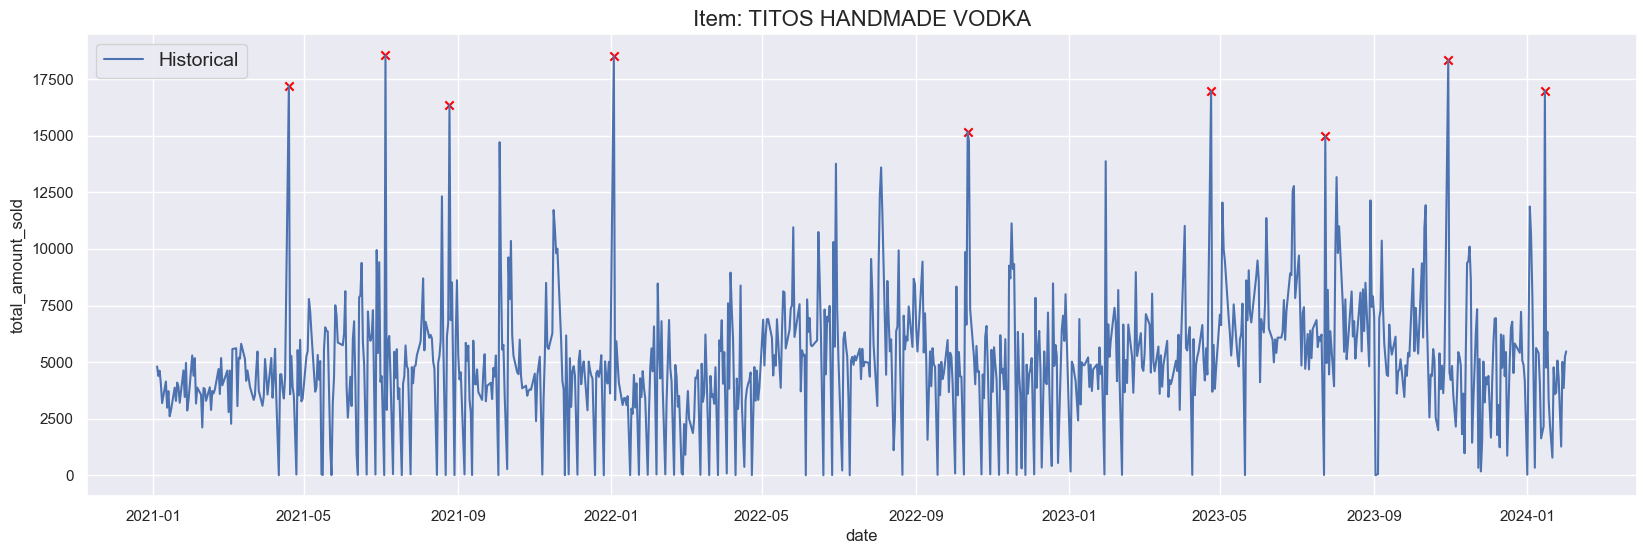

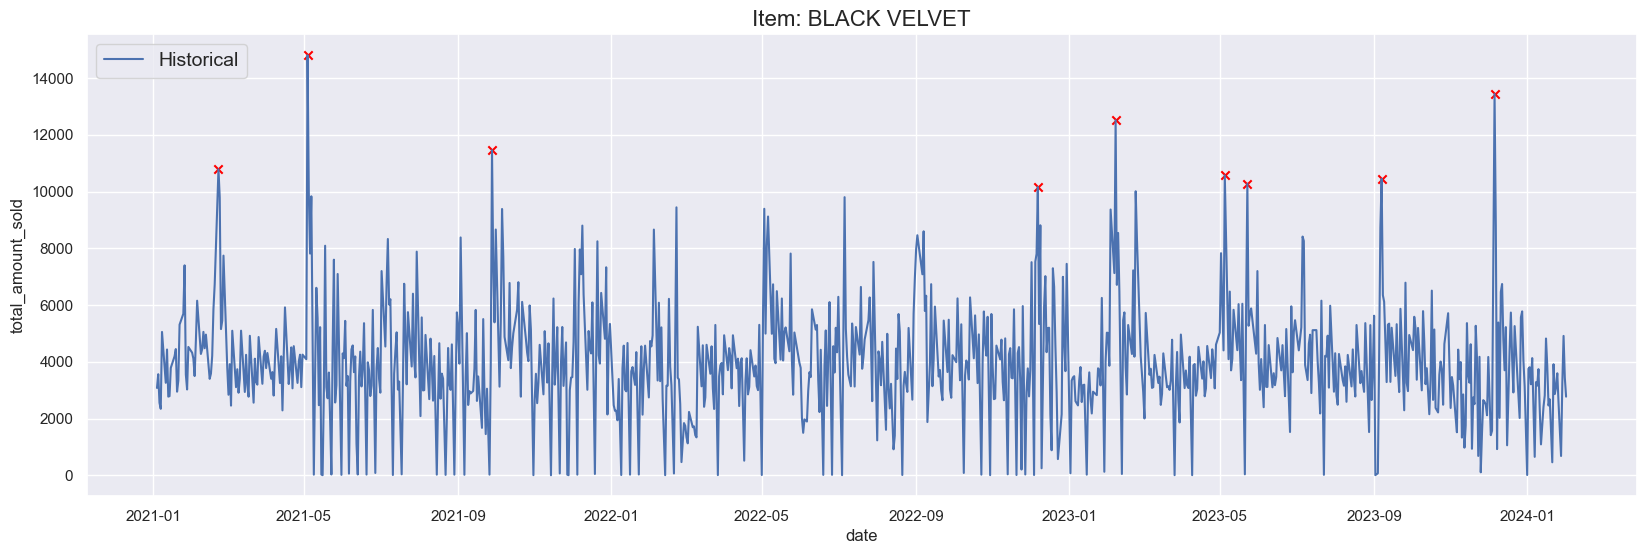

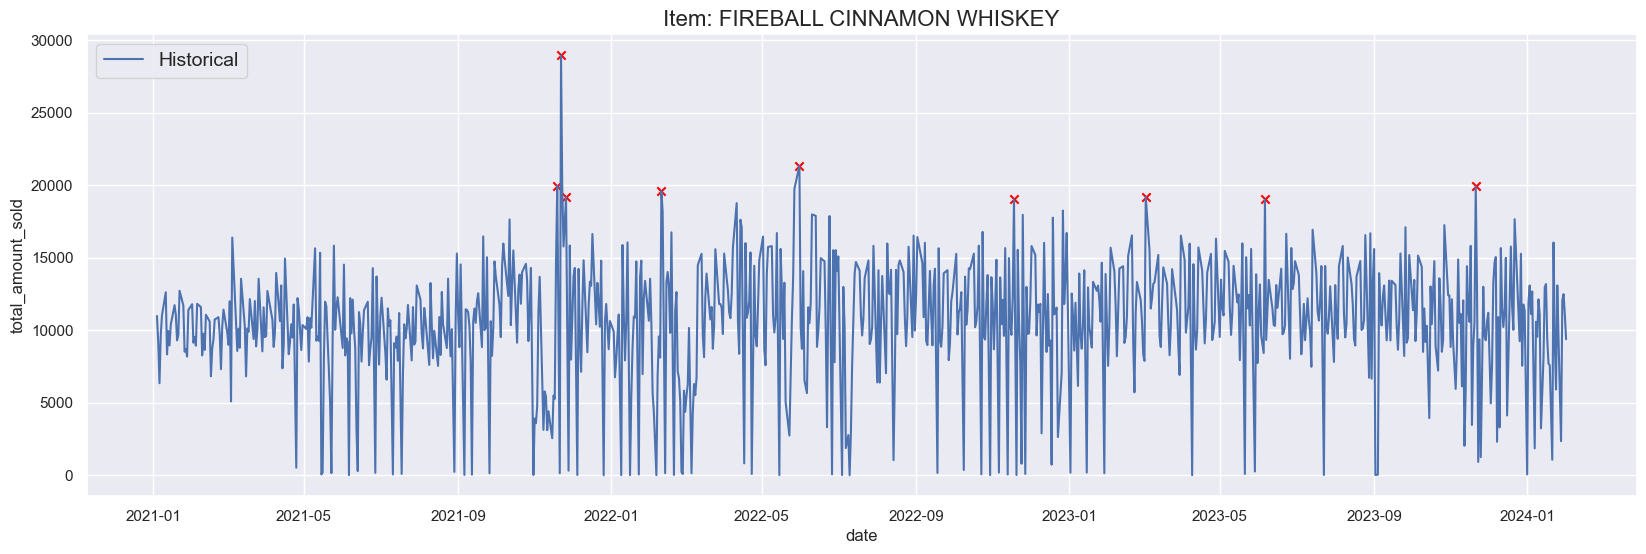

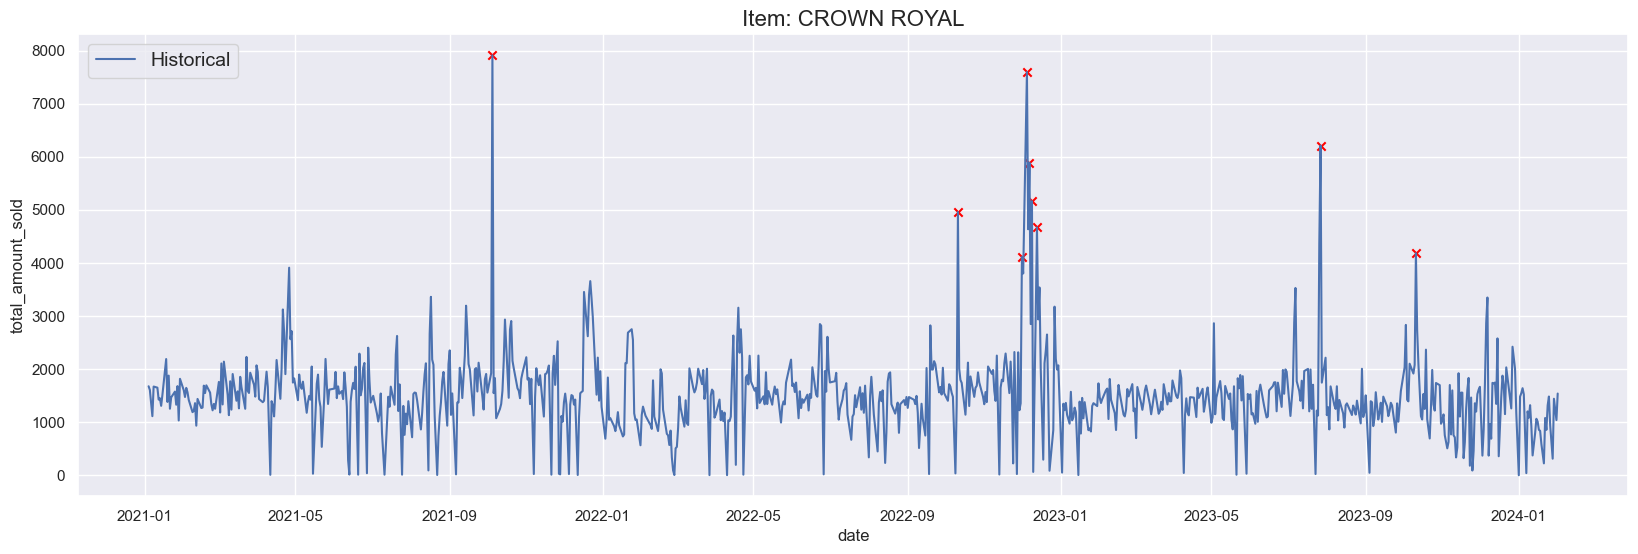

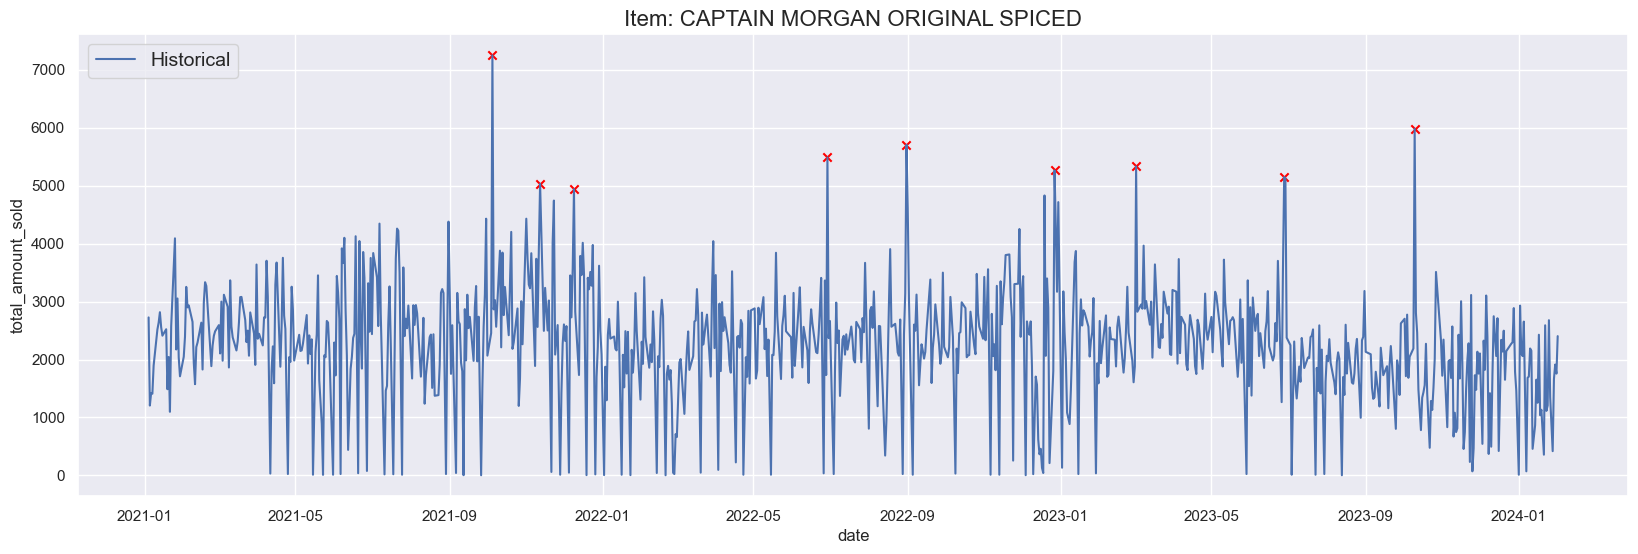

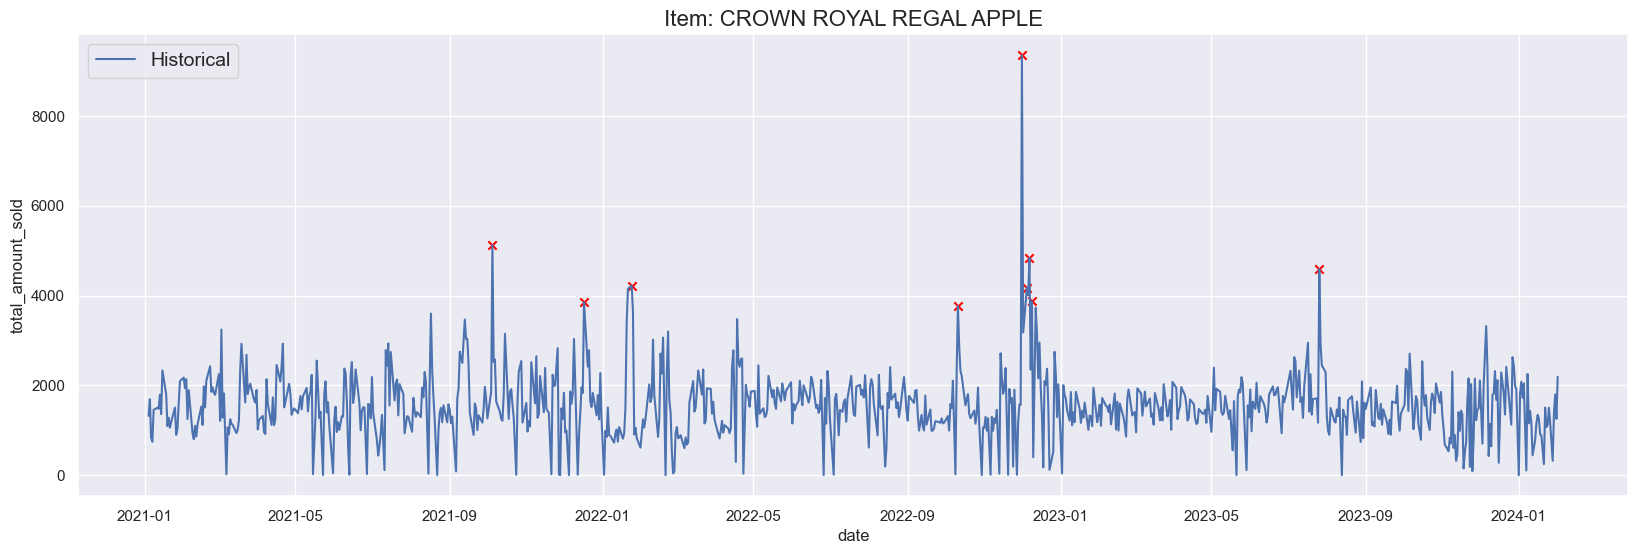

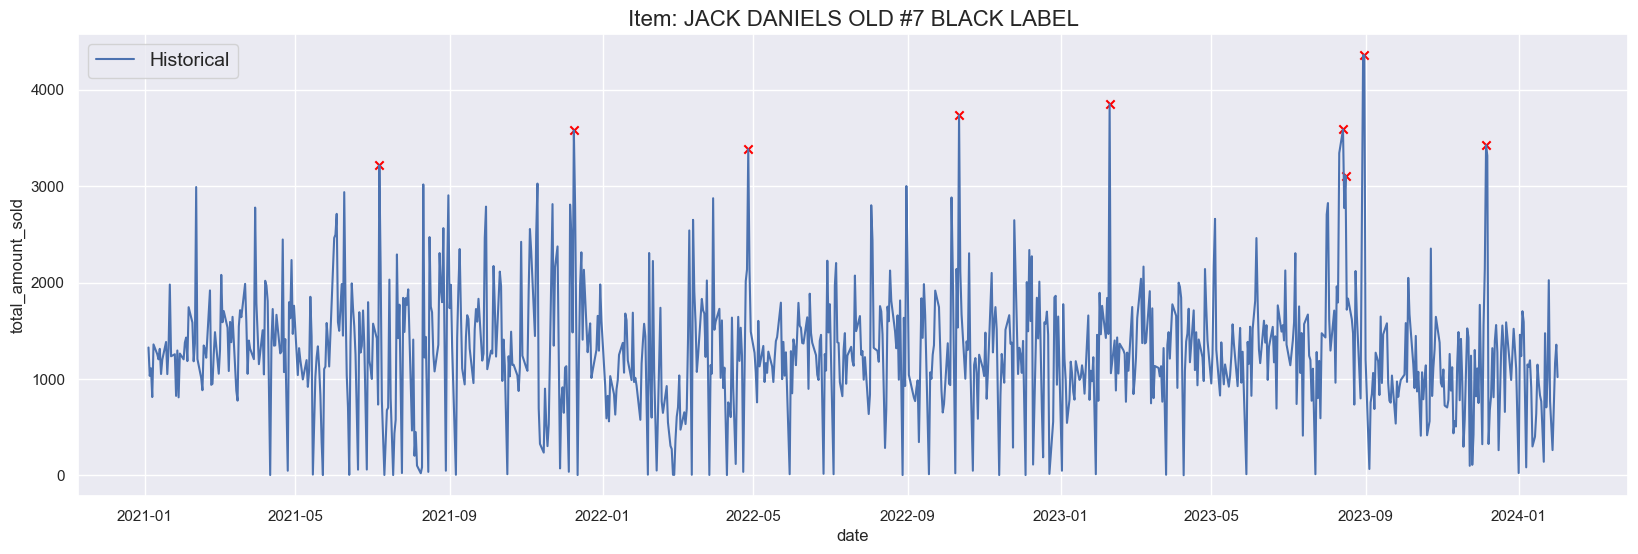

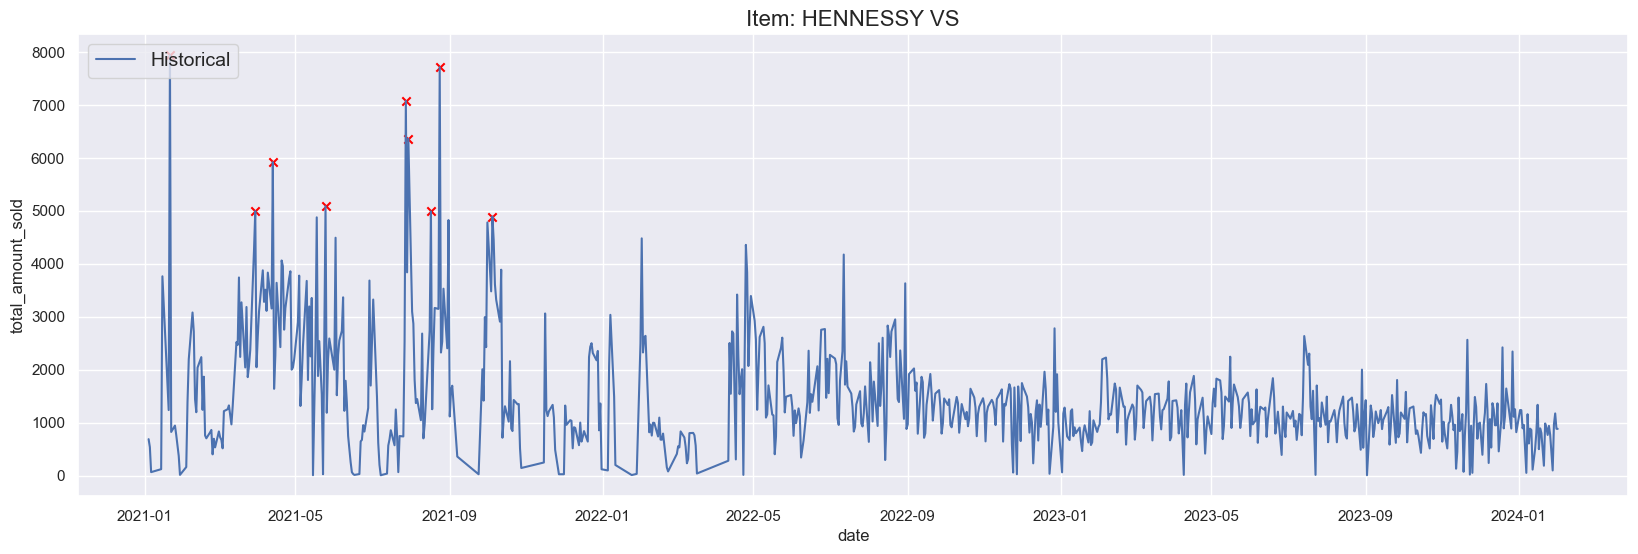

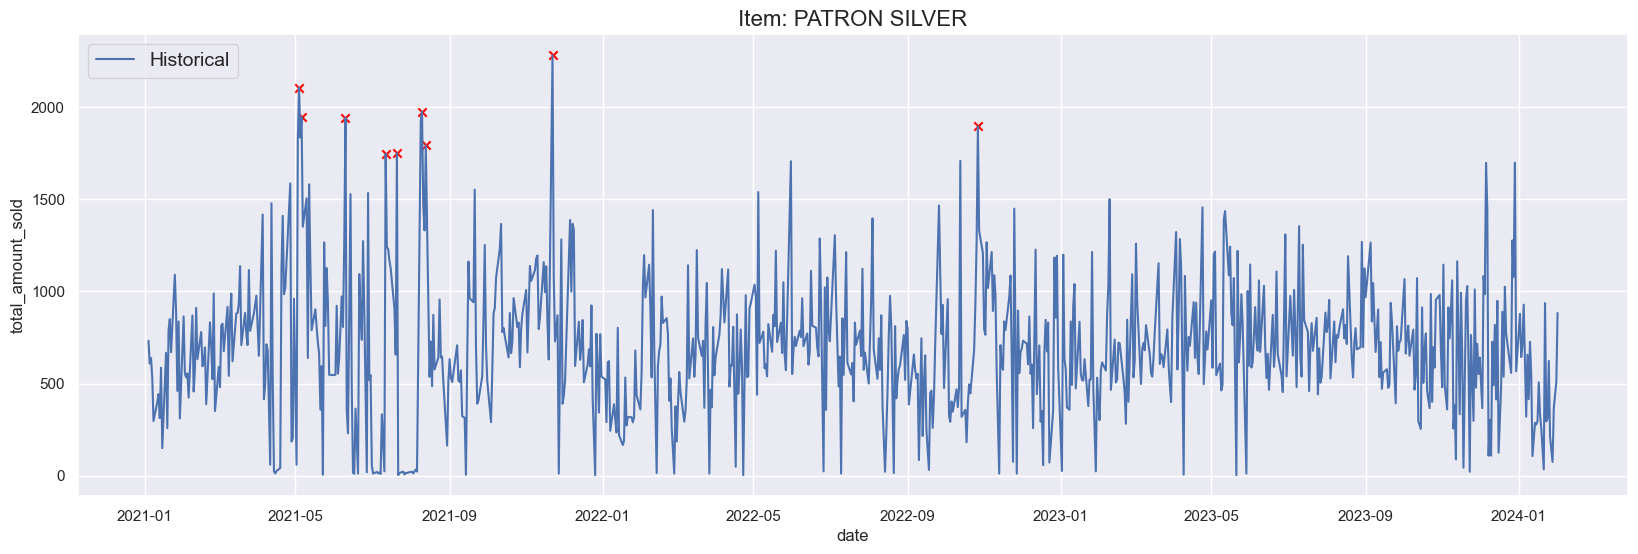

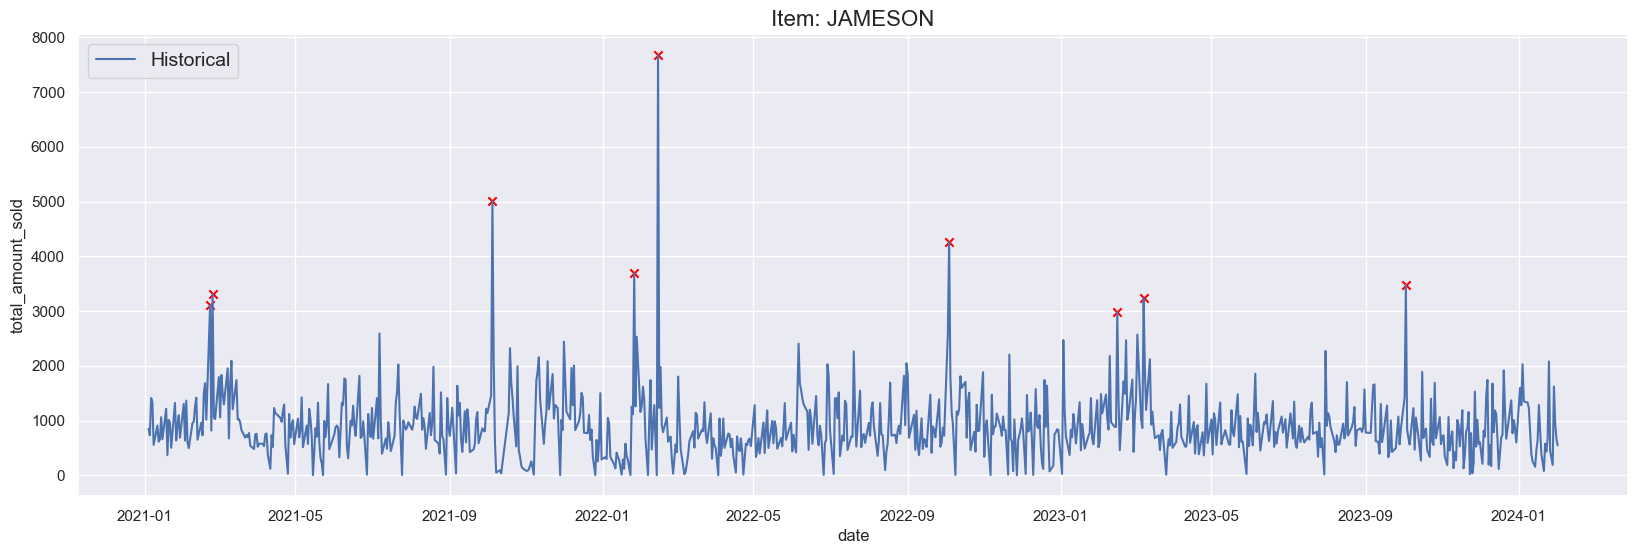

In [62]:
items_list = train_df_groups.iloc[:10].index.to_list()

for item in items_list:
    datah = train_df[train_df.item_name==item]
    plot_historical_and_forecast(
        input_timeseries=datah,
        timestamp_col_name="date",
        data_col_name="total_amount_sold",
        forecast_output=None,
        actual=None,
        title=f'Item: {item}'
    )

I0000 00:00:1722842725.289890  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


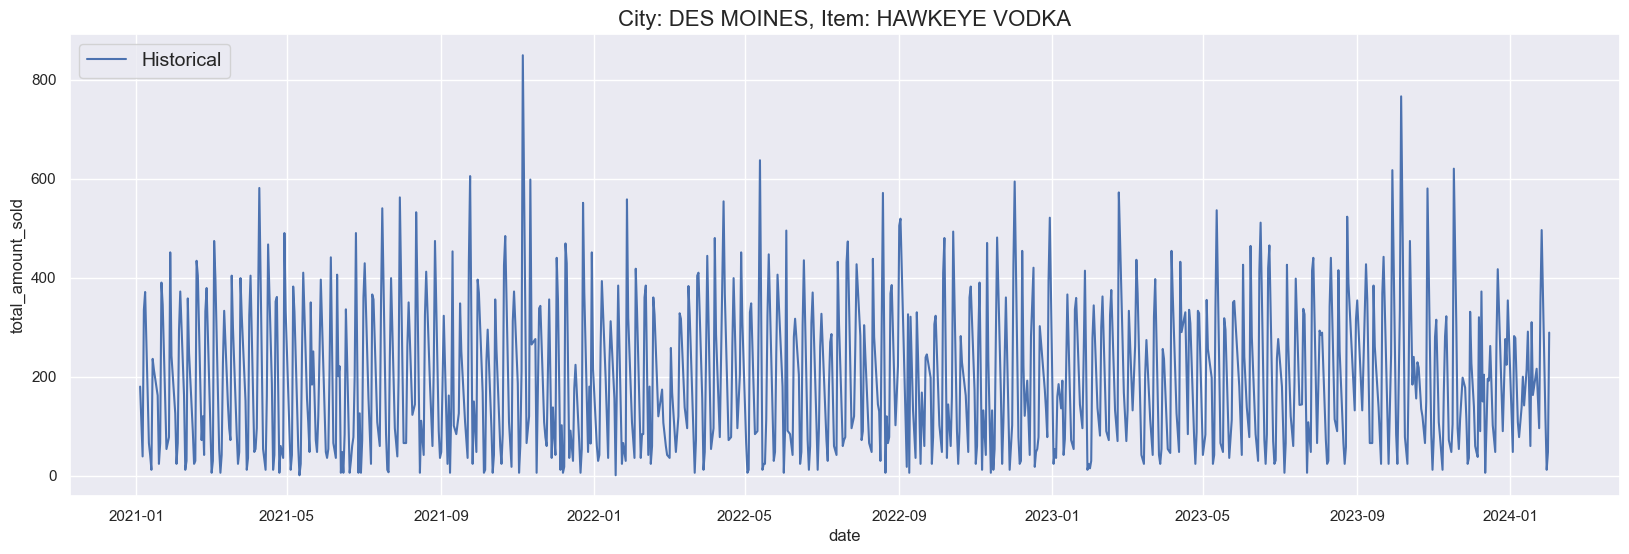

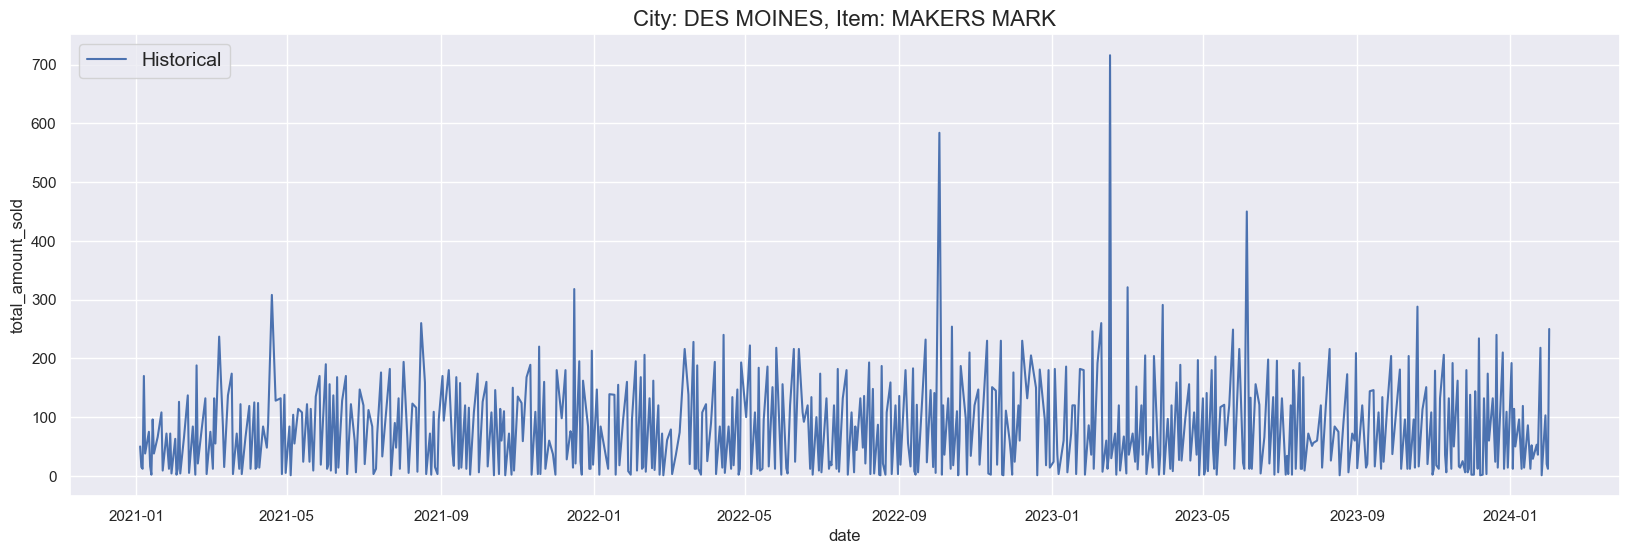

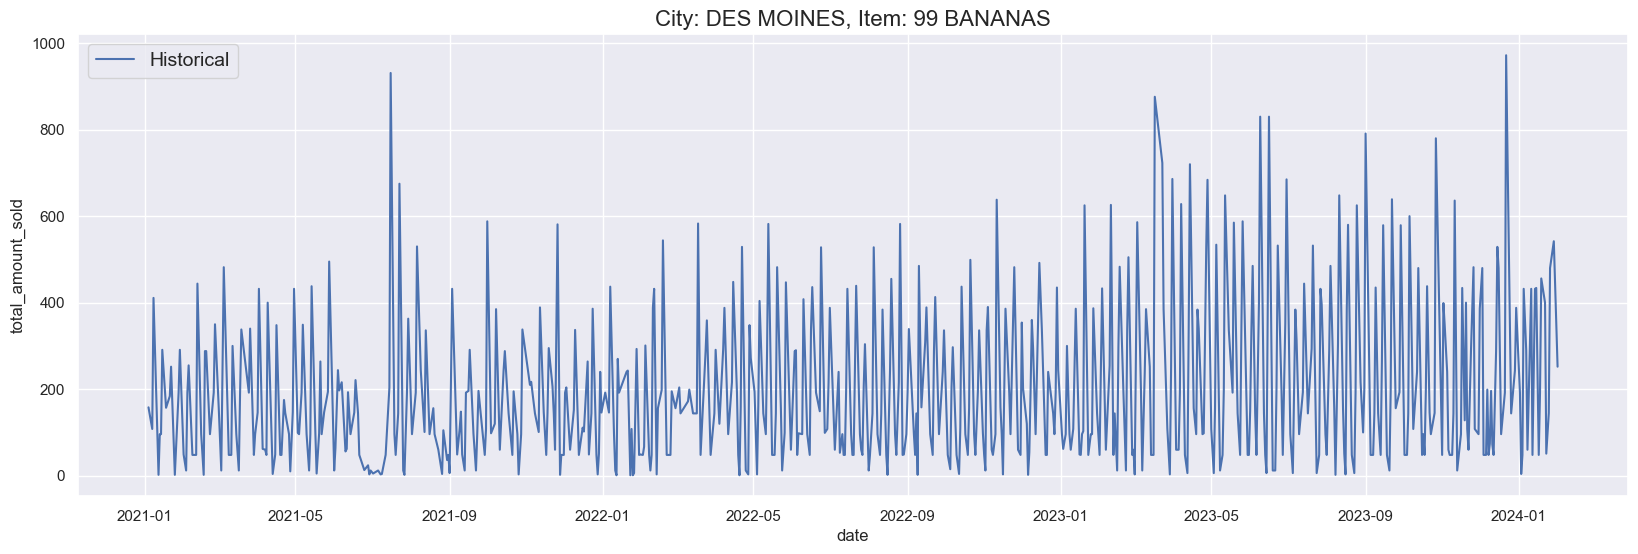

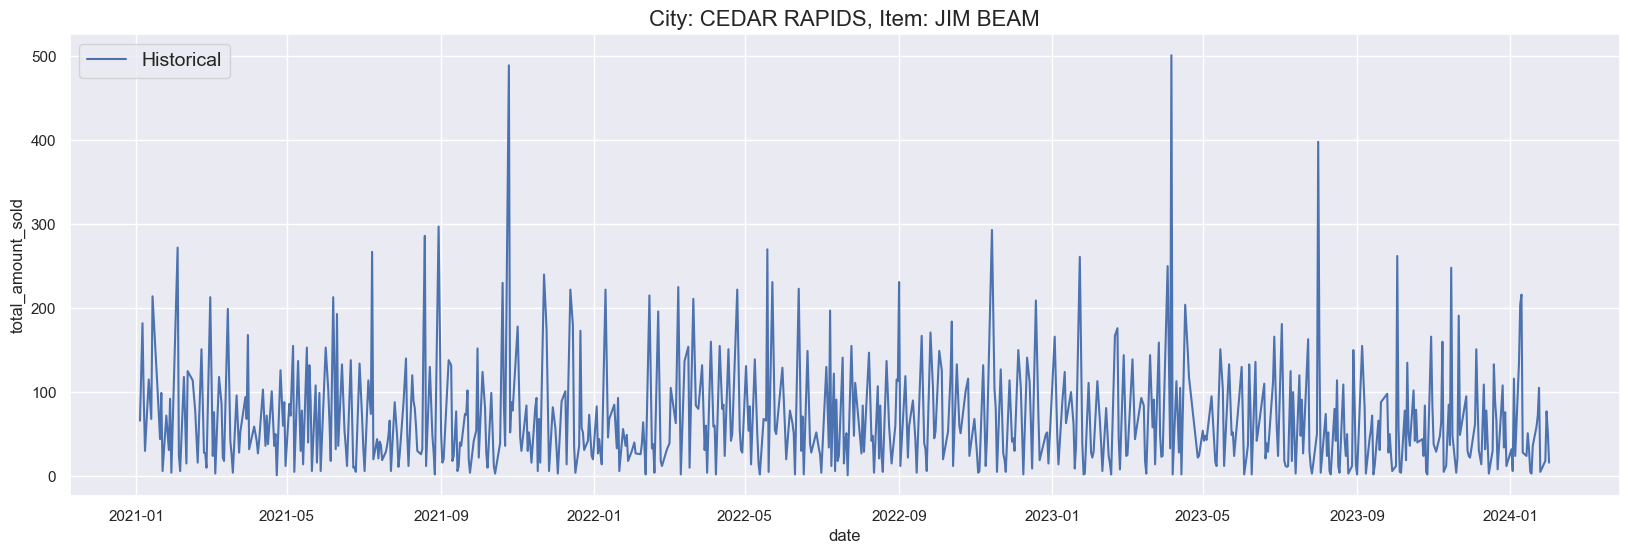

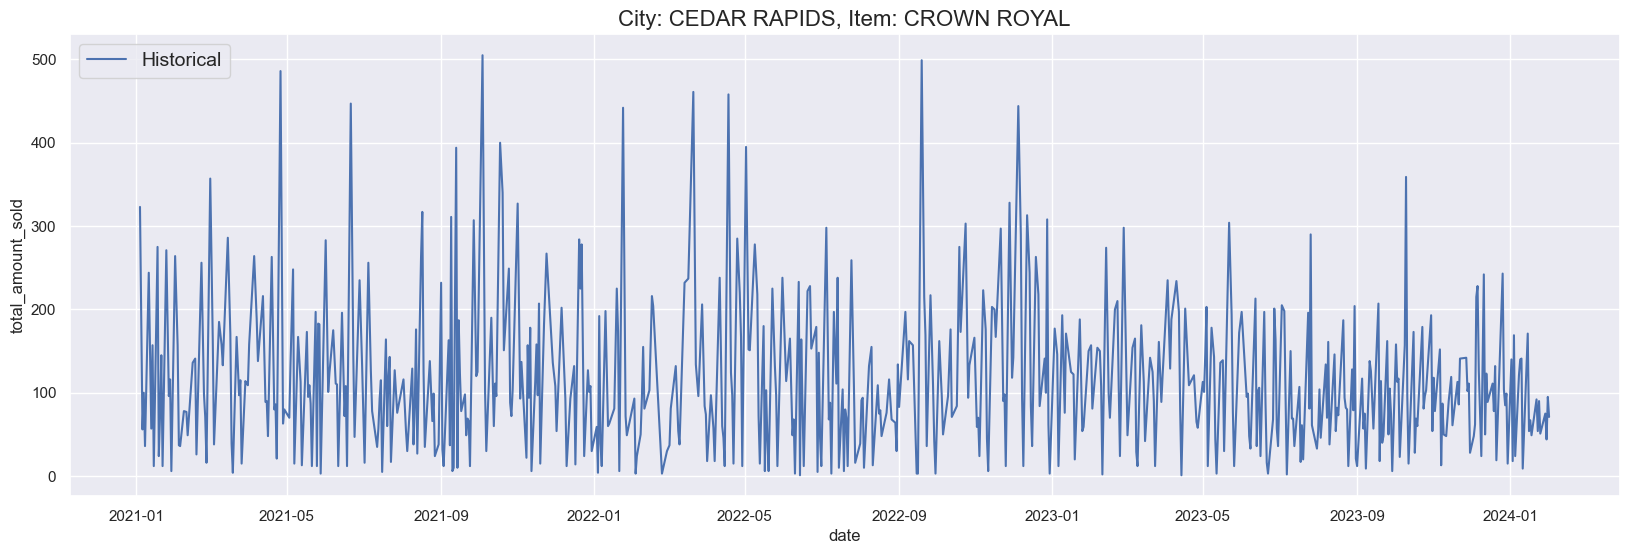

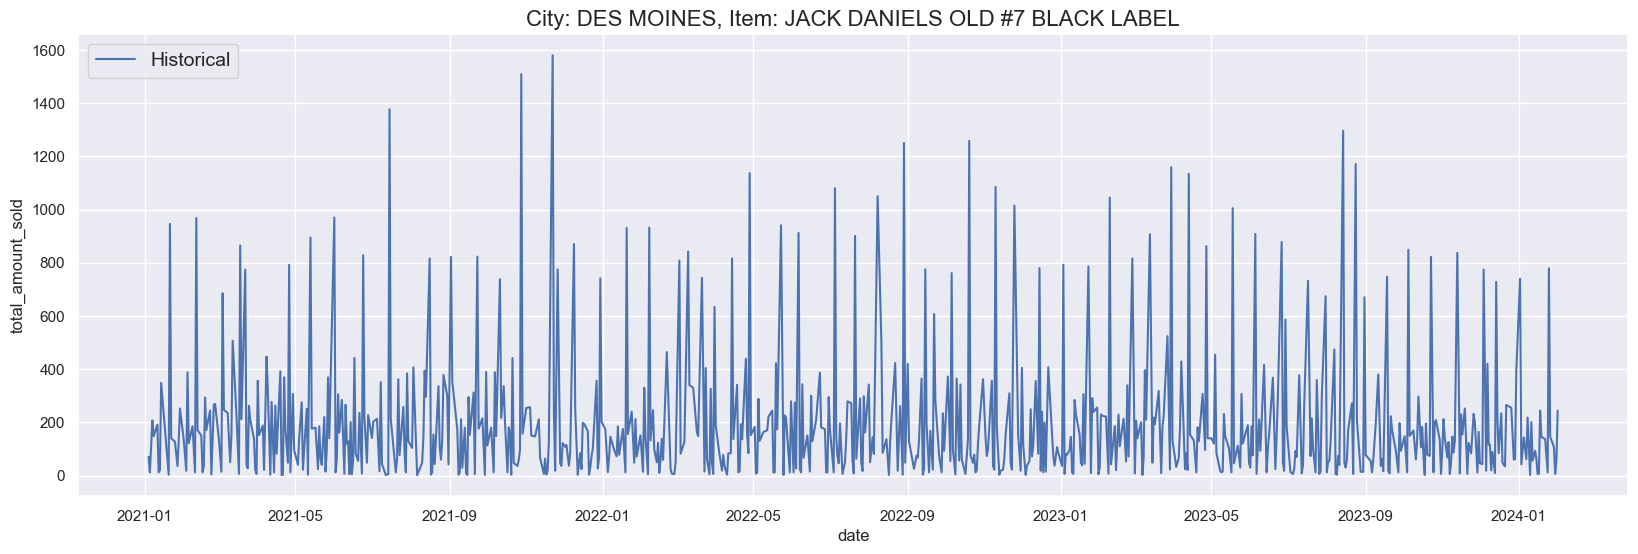

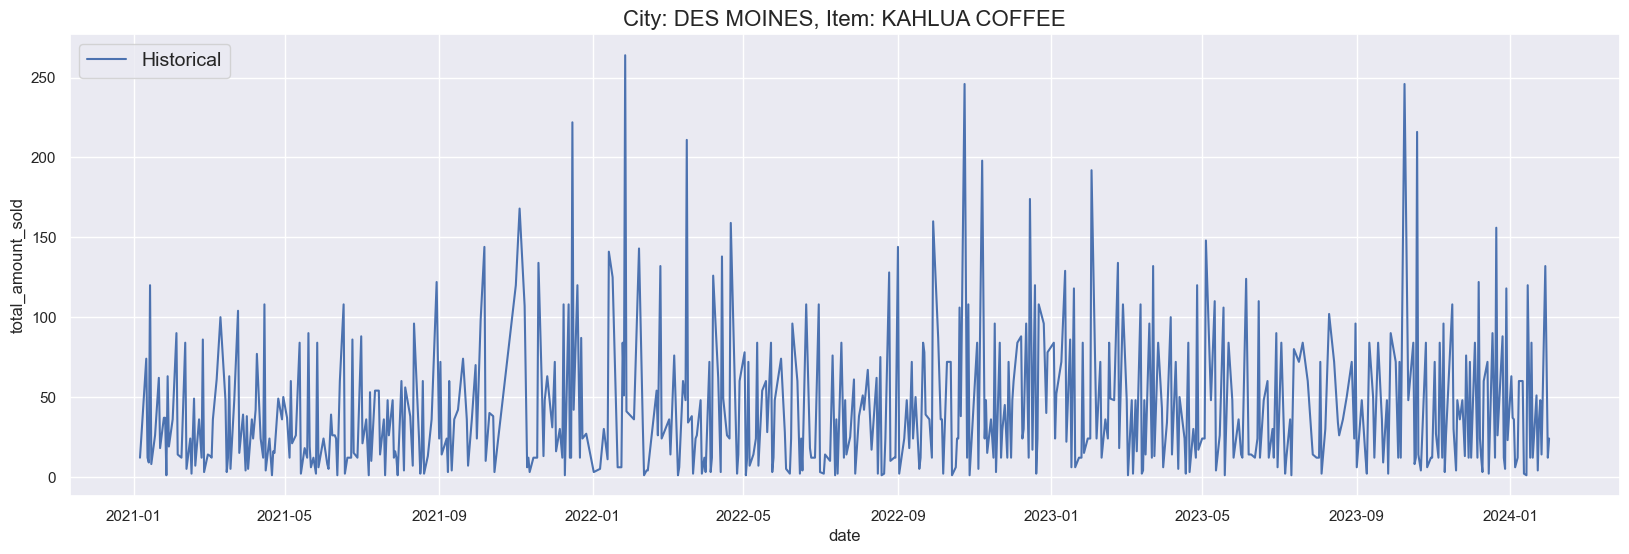

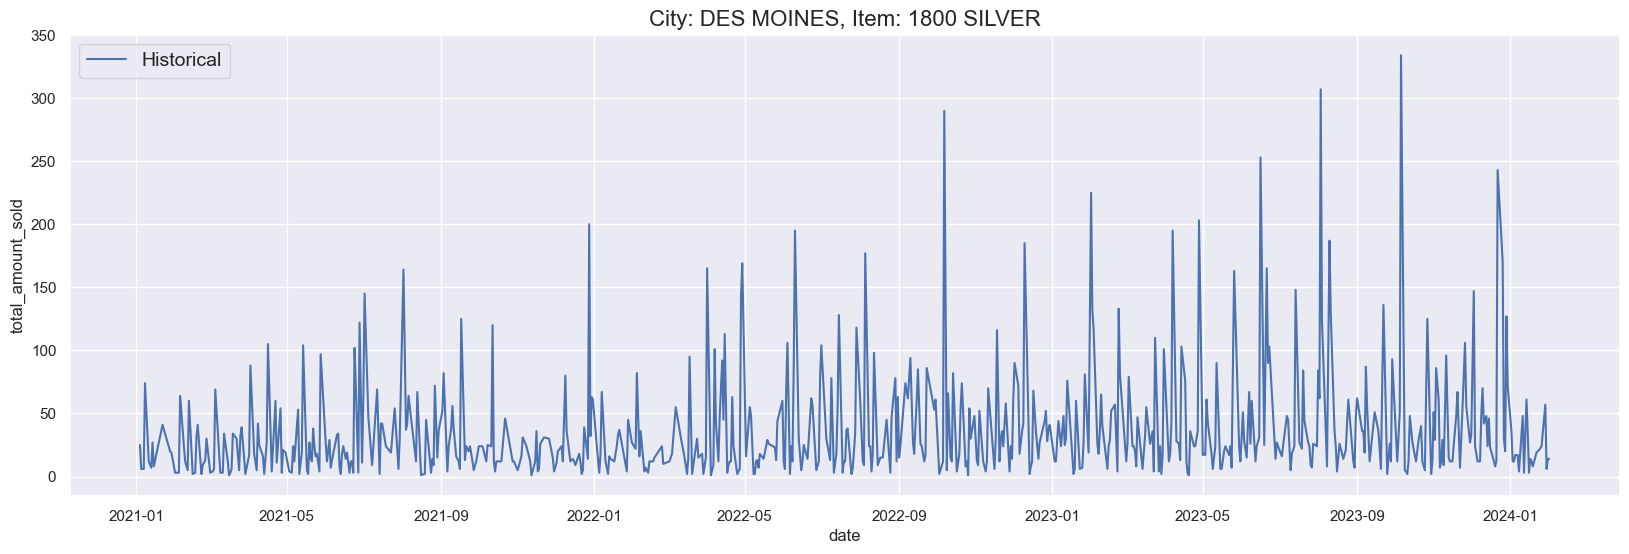

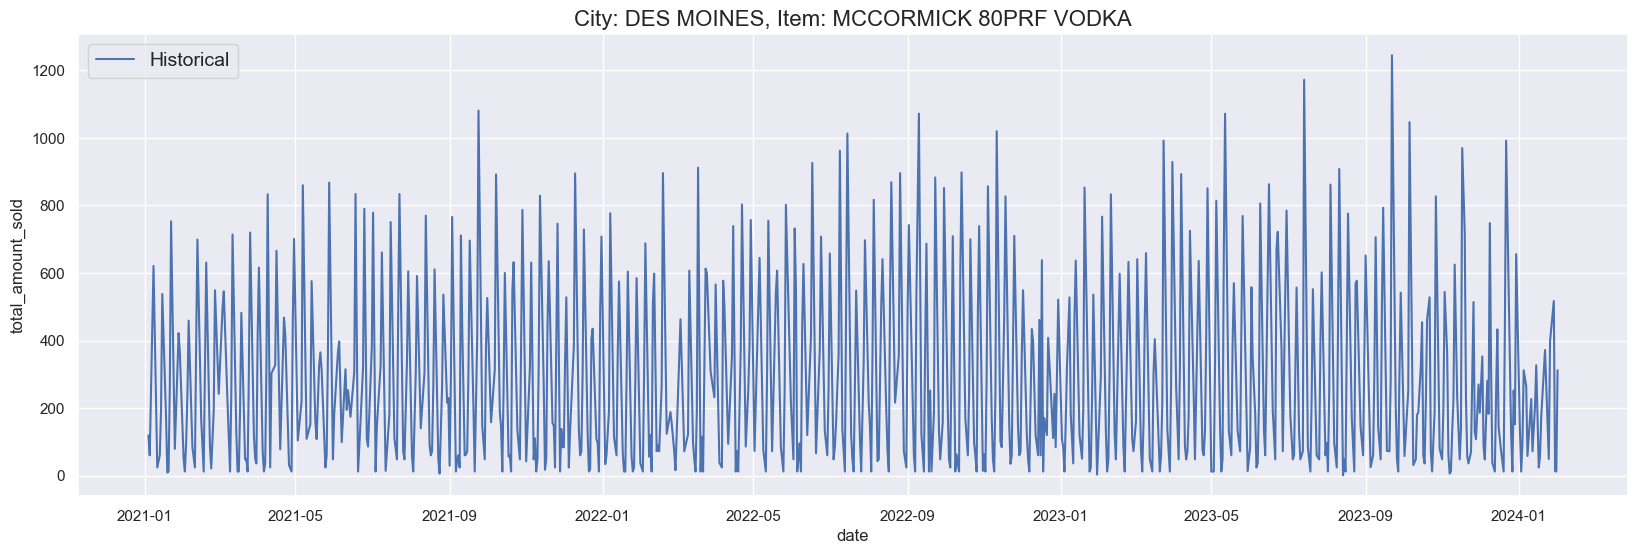

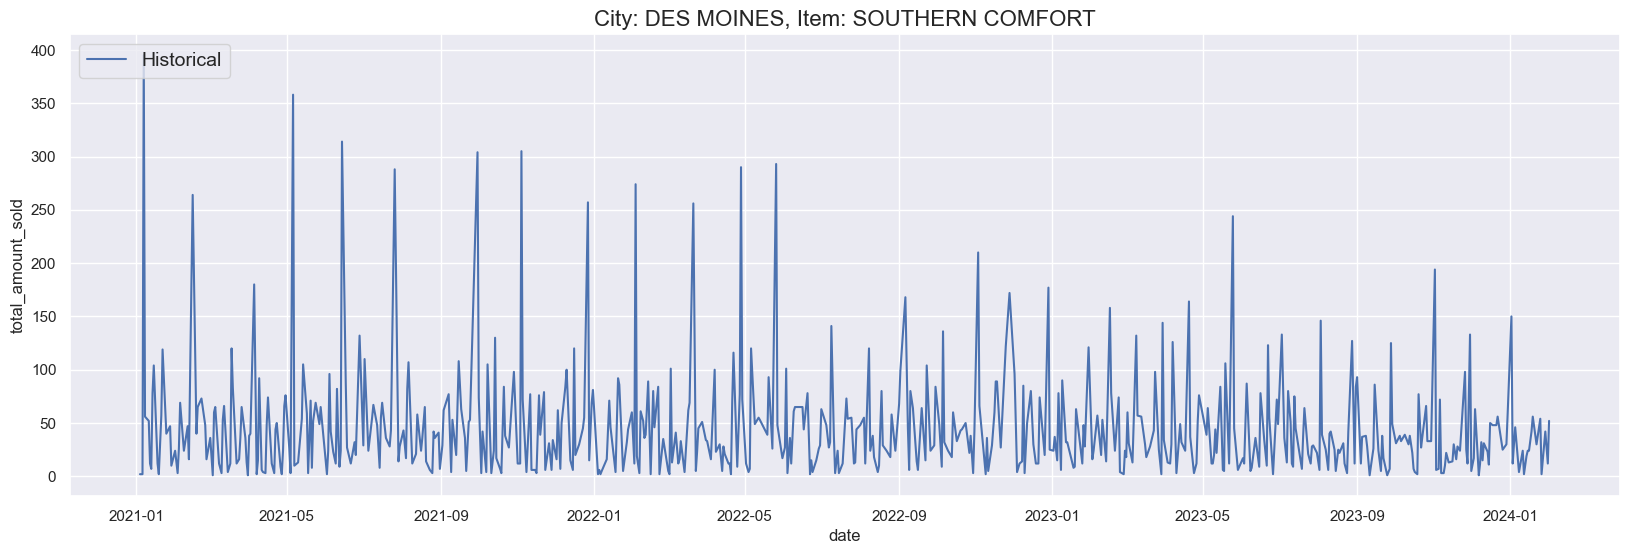

In [118]:
training_data_query = f"""
WITH sales_data AS (
    SELECT 
        city,
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold,
        AVG(state_bottle_retail) AS avg_bottle_price,
        SUM(volume_sold_liters) AS total_volume_sold_liters,
        SUM(sale_dollars) AS total_sale_dollars,
        AVG(state_bottle_retail - state_bottle_cost) AS avg_bottle_profit
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE
        bottles_sold > 0
        AND sale_dollars > 0
        AND city IS NOT NULL
    GROUP BY
        city, date, item_name
    HAVING
        date >= DATE('{OFFSET_START_DATE}')
),
filtered_sales AS (
    SELECT
        sd.city,
        sd.date,
        sd.item_name,
        sd.total_amount_sold,
        sd.avg_bottle_price,
        sd.total_volume_sold_liters,
        sd.total_sale_dollars,
        sd.avg_bottle_profit
    FROM
        sales_data AS sd
    INNER JOIN
        (
            SELECT
                d2.city,
                d2.item_name
            FROM
                (
                    SELECT
                        sd.city,
                        sd.item_name,
                        EXTRACT(YEAR FROM date) AS year
                    FROM
                        sales_data AS sd
                    WHERE
                        sd.date BETWEEN DATE('{START_DATE}') AND DATE('{END_DATE}')
                    GROUP BY
                        year, sd.city, sd.item_name 
                    HAVING
                        SUM(sd.total_amount_sold) > 100  -- Adjust the threshold as needed
                        AND COUNT(DISTINCT sd.date) > 180
                ) AS d2
            GROUP BY
                d2.city, d2.item_name
            HAVING
                COUNT(DISTINCT d2.year) >= 3
        ) AS d3
    ON
        sd.city = d3.city
        AND sd.item_name = d3.item_name
    INNER JOIN
        (
            SELECT
                d4.city,
                d4.item_name,
                MAX(EXTRACT(YEAR FROM date)) AS max_year
            FROM
                sales_data AS d4
            GROUP BY
                d4.city, d4.item_name 
            HAVING
                max_year = 2024
        ) AS d5
    ON
        sd.city = d5.city
        AND sd.item_name = d5.item_name
)
SELECT
    city,
    date,
    item_name,
    total_amount_sold,
    avg_bottle_price,
    total_volume_sold_liters,
    total_sale_dollars,
    avg_bottle_profit,
    -- 7-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_sale_dollars,
    -- 30-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_sale_dollars,
FROM
    filtered_sales
WHERE
    date BETWEEN DATE('{START_DATE}') AND DATE('{END_DATE}')
ORDER BY
    city, item_name, date
"""

training_data_query_job = client.query(training_data_query)
df_train = training_data_query_job.to_dataframe()

city_items_list = df_train[["city", "item_name"]].drop_duplicates()
city_items_list_sample = city_items_list.sample(10)

for _, row in city_items_list_sample.iterrows():
    datah = df_train[(df_train.item_name==row["item_name"]) & (df_train.city==row["city"])]
    plot_historical_and_forecast(input_timeseries=datah,
                                 timestamp_col_name="date",
                                 data_col_name="total_amount_sold",
                                 forecast_output=None,
                                 actual=None,
                                 title=f'City: {row["city"]}, Item: {row["item_name"]}')

## Querying Training Data

Constructing and executing a SQL query to retrieve training data from the
<code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">bigquery-public-data.iowa_liquor_sales.sales</code> table.
This query aggregates sales data for each item by date within the specified date range and loads the result into a DataFrame.

- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">training_data_query</code>: A multi-line string containing the SQL <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">SELECT</code> statement.
  - <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">date</code>: Selects the date of the sale.
  - <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">item_description AS item_name</code>: Renames the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">item_description</code> column to <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">item_name</code>.
  - <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">SUM(bottles_sold) AS total_amount_sold</code>: Aggregates the total number of bottles sold for each item by date.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">FROM \`bigquery-public-data.iowa_liquor_sales.sales\`</code>: Specifies the table from which to query the data.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">GROUP BY date, item_name</code>: Groups the results by date and item name.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">HAVING date BETWEEN DATE('2023-01-01') AND DATE('2024-01-01')</code>: Filters the results to include only sales within the specified date range.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">training_data_query_job = client.query(training_data_query)</code>: Submits the query using the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">client.query</code> method.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">df_train = training_data_query_job.to_dataframe()</code>: Converts the query result to a Pandas DataFrame.
- <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">df_train</code>: Displays the DataFrame containing the training data.

<b style="color:#e83e8c">Note:</b> Ensure that the <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">bigquery-public-data</code> dataset is accessible and that the date range is accurate for your analysis.

In [58]:
training_data_table_creation_query = f"""
CREATE OR REPLACE VIEW bqmlforecast.training_data AS
(
WITH sales_data AS (
    SELECT 
        city,
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold,
        AVG(state_bottle_retail) AS avg_bottle_price,
        SUM(volume_sold_liters) AS total_volume_sold_liters,
        SUM(sale_dollars) AS total_sale_dollars,
        AVG(state_bottle_retail - state_bottle_cost) AS avg_bottle_profit
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE
        bottles_sold > 0
        AND sale_dollars > 0
        AND city IS NOT NULL
    GROUP BY
        city, date, item_name
    HAVING
        date >= DATE('{OFFSET_START_DATE}')
),
filtered_sales AS (
    SELECT
        sd.city,
        sd.date,
        sd.item_name,
        sd.total_amount_sold,
        sd.avg_bottle_price,
        sd.total_volume_sold_liters,
        sd.total_sale_dollars,
        sd.avg_bottle_profit
    FROM
        sales_data AS sd
    INNER JOIN
        (
            SELECT
                d2.city,
                d2.item_name
            FROM
                (
                    SELECT
                        sd.city,
                        sd.item_name,
                        EXTRACT(YEAR FROM date) AS year
                    FROM
                        sales_data AS sd
                    WHERE
                        sd.date BETWEEN DATE('{START_DATE}') AND DATE('{END_DATE}')
                    GROUP BY
                        year, sd.city, sd.item_name 
                    HAVING
                        SUM(sd.total_amount_sold) > 100  -- Adjust the threshold as needed
                        AND COUNT(DISTINCT sd.date) > 180
                ) AS d2
            GROUP BY
                d2.city, d2.item_name
            HAVING
                COUNT(DISTINCT d2.year) >= 3
        ) AS d3
    ON
        sd.city = d3.city
        AND sd.item_name = d3.item_name
    INNER JOIN
        (
            SELECT
                d4.city,
                d4.item_name,
                MAX(EXTRACT(YEAR FROM date)) AS max_year
            FROM
                sales_data AS d4
            GROUP BY
                d4.city, d4.item_name 
            HAVING
                max_year = 2024
        ) AS d5
    ON
        sd.city = d5.city
        AND sd.item_name = d5.item_name
)
SELECT
    city,
    date,
    item_name,
    total_amount_sold,
    avg_bottle_price,
    total_volume_sold_liters,
    total_sale_dollars,
    avg_bottle_profit,
    -- 7-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_sale_dollars,
    -- 30-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_sale_dollars,
    -- 60-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS ma60_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS ma60_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS ma60_total_sale_dollars
FROM
    filtered_sales
WHERE
    date BETWEEN DATE('{START_DATE}') AND DATE('{END_DATE}')
ORDER BY
    city, item_name, date
)
"""
training_data_table_creation_job = client.query(training_data_table_creation_query)
print(training_data_table_creation_job.result())

In [60]:
test_data_table_creation_query = f"""
CREATE OR REPLACE VIEW bqmlforecast.test_data AS
(
WITH sales_data AS (
    SELECT 
        city,
        date,
        item_description AS item_name,
        SUM(bottles_sold) AS total_amount_sold,
        AVG(state_bottle_retail) AS avg_bottle_price,
        SUM(volume_sold_liters) AS total_volume_sold_liters,
        SUM(sale_dollars) AS total_sale_dollars,
        AVG(state_bottle_retail - state_bottle_cost) AS avg_bottle_profit
    FROM
        `bigquery-public-data.iowa_liquor_sales.sales`
    WHERE
        bottles_sold > 0
        AND sale_dollars > 0
        AND city IS NOT NULL
    GROUP BY
        city, date, item_name
    HAVING
        date >= DATE('{OFFSET_START_DATE}')
),
filtered_sales AS (
    SELECT
        sd.city,
        sd.date,
        sd.item_name,
        sd.total_amount_sold,
        sd.avg_bottle_price,
        sd.total_volume_sold_liters,
        sd.total_sale_dollars,
        sd.avg_bottle_profit
    FROM
        sales_data AS sd
    INNER JOIN
        (
            SELECT
                DISTINCT item_name, city
            FROM
                `bunge-demo.bqmlforecast.training_data`
        ) AS d2
    ON
        sd.city = d2.city
        AND sd.item_name = d2.item_name
)
SELECT
    city,
    date,
    item_name,
    total_amount_sold,
    avg_bottle_price,
    total_volume_sold_liters,
    total_sale_dollars,
    avg_bottle_profit,
    -- 7-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS ma7_total_sale_dollars,
    -- 30-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 29 PRECEDING AND CURRENT ROW) AS ma30_total_sale_dollars,
    -- 60-day moving averages
    AVG(total_amount_sold) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS ma60_total_amount_sold,
    AVG(avg_bottle_price) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS ma60_avg_bottle_price,
    AVG(total_sale_dollars) OVER (PARTITION BY city, item_name ORDER BY date ROWS BETWEEN 59 PRECEDING AND CURRENT ROW) AS ma60_total_sale_dollars
FROM
    filtered_sales
WHERE
    date >= DATE('{END_DATE}')
ORDER BY
    city, item_name, date
)
"""
test_data_table_creation_job = client.query(test_data_table_creation_query)
print(test_data_table_creation_job.result())

In [83]:
create_model_query = """
CREATE OR REPLACE MODEL bqmlforecast.arima_model

OPTIONS(
  MODEL_TYPE='ARIMA',
  TIME_SERIES_TIMESTAMP_COL='date', 
  TIME_SERIES_DATA_COL='total_amount_sold',
  TIME_SERIES_ID_COL=['city', 'item_name'],
  HOLIDAY_REGION='US'
) AS
SELECT 
    date,
    city,
    item_name,
    SUM(total_amount_sold) AS total_amount_sold
FROM
  bqmlforecast.training_data
GROUP BY
    city,
    item_name,
    date
"""
create_model_job = client.query(create_model_query)
print(create_model_job.result())

In [102]:
city = 'DES MOINES'
item_name = 'FIREBALL CINNAMON WHISKEY'

create_model_query = f"""
CREATE OR REPLACE MODEL bqmlforecast.arima_plus_xreg_model

OPTIONS(
  MODEL_TYPE='ARIMA_PLUS_XREG',
  TIME_SERIES_TIMESTAMP_COL='date',
  TIME_SERIES_DATA_COL='total_amount_sold',
  HOLIDAY_REGION='US',
  AUTO_ARIMA=True,
  ADJUST_STEP_CHANGES=True,
  CLEAN_SPIKES_AND_DIPS=True
) AS

SELECT 
    date,
    city,
    item_name,
    total_amount_sold,
    total_volume_sold_liters,
    avg_bottle_price,
    total_sale_dollars,
    avg_bottle_profit,
    ma7_total_amount_sold,
    ma7_avg_bottle_price,
    ma7_total_sale_dollars,
    ma30_total_amount_sold,
    ma30_avg_bottle_price,
    ma30_total_sale_dollars,
    ma60_total_amount_sold,
    ma60_avg_bottle_price,
    ma60_total_sale_dollars
FROM
  bqmlforecast.training_data
WHERE
    city = '{city}' AND item_name = '{item_name}'
"""
create_model_job = client.query(create_model_query)
print(create_model_job.result())

In [125]:
def normalize_item_name(item_name):
    # Convert to lowercase
    city = city.lower()
    item_name = item_name.lower()

    # Replace spaces with underscores
    city = city.replace(' ', '_')
    item_name = item_name.replace(' ', '_')

    # Concatenate city and item_name with an underscore
    city_item_name = f"{city}_{item_name}"
    return city_item_name


for _, row in tqdm(city_items_list.iterrows(), total=city_items_list.shape[0], desc="Creating models"):
    city = row['city']
    item_name = row['item_name']
    city_item_name = normalize_city_item_name(city, item_name)
    
    create_model_query = f"""
    CREATE OR REPLACE MODEL bqmlforecast.arima_plus_xreg_model_{city_item_name}
    
    OPTIONS(
      MODEL_TYPE='ARIMA_PLUS_XREG',
      TIME_SERIES_TIMESTAMP_COL='date',
      TIME_SERIES_DATA_COL='total_amount_sold',
      HOLIDAY_REGION='US',
      AUTO_ARIMA=True,
      ADJUST_STEP_CHANGES=True,
      CLEAN_SPIKES_AND_DIPS=True
    ) AS
    
    SELECT 
        date,
        city,
        item_name,
        total_amount_sold,
        total_volume_sold_liters,
        avg_bottle_price,
        total_sale_dollars,
        avg_bottle_profit,
        ma7_total_amount_sold,
        ma7_avg_bottle_price,
        ma7_total_sale_dollars,
        ma30_total_amount_sold,
        ma30_avg_bottle_price,
        ma30_total_sale_dollars,
        ma60_total_amount_sold,
        ma60_avg_bottle_price,
        ma60_total_sale_dollars
    FROM
      bqmlforecast.training_data
    WHERE
        city = '{city}' AND item_name = '{item_name}'
    """
    try:
        create_model_job = client.query(create_model_query)
        create_model_job.result()
    except Exception as exc:
        print(exc)
        max_tries = 3
        tries = 1
        success = False
        while not success and tries <= max_tries:
            tries += 1
            try:
                create_model_job = client.query(create_model_query)
                create_model_job.result()
                success = True
            except Exception as exc:
                sleep_time = 120 * tries
                print(exc)
                print(f"Sleeping for {sleep_time:,.0f} seconds...")
                time.sleep(sleep_time)


Creating models:   0%|                                                                                                                                                                 | 0/65 [00:00<?, ?it/s]

403 GET https://bigquery.googleapis.com/bigquery/v2/projects/bunge-demo/queries/05fcc977-e2ef-4934-868f-24561ed44d2e?maxResults=0&location=US&prettyPrint=false: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 05fcc977-e2ef-4934-868f-24561ed44d2e



Creating models:   0%|                                                                                                                                                                 | 0/65 [00:04<?, ?it/s]

403 GET https://bigquery.googleapis.com/bigquery/v2/projects/bunge-demo/queries/2c2a041a-c1dc-4cb2-baaa-313690c4577d?maxResults=0&location=US&prettyPrint=false: Quota exceeded: Your project exceeded quota for free query bytes scanned. For more information, see https://cloud.google.com/bigquery/docs/troubleshoot-quotas

Location: US
Job ID: 2c2a041a-c1dc-4cb2-baaa-313690c4577d

Sleeping for 240 seconds...


NameError: name 'time' is not defined

In [71]:
evaluate_query = """
SELECT
  *
FROM
  ML.EVALUATE(MODEL bqmlforecast.arima_plus_xreg_model)
"""

evaluate_job = client.query(evaluate_query)
df_eval = evaluate_job.to_dataframe()
df_eval

I0000 00:00:1722838782.228474  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


non_seasonal_p  non_seasonal_d  non_seasonal_q  has_drift  log_likelihood  \
0                0               1               5      False       -5388.762   
1                0               1               5       True       -5392.971   
2                1               1               2       True       -5483.935   
3                3               1               1       True       -5483.099   
4                2               1               1       True       -5484.408   
5                3               1               1      False       -5484.512   
6                2               1               1      False       -5485.756   
7                1               1               3       True       -5484.184   
8                1               1               1       True       -5486.348   
9                4               1               1      False       -5484.511   
10               1               1               1      False       -5487.572   
11               2               1               3       True       -5483.769   
12               1               1               2      False       -5486.834   
13               1               1               3      False       -5485.957   
14               2               1               3      False       -5485.205   
15               2               1               2       True       -5485.336   
16               3               1               2       True       -5484.352   
17               2               1               2      False       -5486.619   
18               3               1               2      False       -5485.715   
19               0               1               4       True       -5487.358   
20               0               1               4      False       -5488.493   
21               1               1               4      False       -5489.000   
22               1               1               4       True       -5488.159   
23               0               1               3      False       -5492.707   
24               0               1               3       True       -5491.813   
25               0               1               2      False       -5504.102   
26               0               1               2       True       -5503.667   
27               4               1               0      False       -5559.646   
28               5               1               0      False       -5559.607   
29               4               1               0       True       -5559.646   
30               0               1               1      False       -5563.695   
31               5               1               0       True       -5559.607   
32               0               1               1       True       -5563.695   
33               4               1               1       True       -5560.095   
34               3               1               0      False       -5564.271   
35               3               1               0       True       -5564.271   
36               2               1               0      False       -5579.176   
37               2               1               0       True       -5579.176   
38               1               1               0      False       -5615.346   
39               1               1               0       True       -5615.347   
40               0               1               0      False       -5685.672   
41               0               1               0       True       -5685.672   

         AIC  variance seasonal_periods  has_holiday_effect  \
0  10789.524   850.427         [WEEKLY]                True   
1  10799.942   859.807         [WEEKLY]                True   
2  10977.870  1015.700         [WEEKLY]                True   
3  10978.199  1014.242         [WEEKLY]                True   
4  10978.816  1016.525         [WEEKLY]                True   
5  10979.025  1019.125         [WEEKLY]                True   
6  10979.511  1021.365         [WEEKLY]                True   
7  10980.369  10

In [73]:
eval_query = f"""
SELECT
  *
FROM
  ML.EVALUATE(
    MODEL `bqmlforecast.arima_plus_xreg_model`,
    (
      SELECT *
      FROM
        `bqmlforecast.test_data`
      WHERE
        date > DATE('{END_DATE}')
        --AND city = '{city}'
        --AND item_name = '{item_name}'
    ),
    STRUCT(
      TRUE AS perform_aggregation,
      30 AS horizon))
"""
eval_query_job = client.query(eval_query)
eval_df = eval_query_job.to_dataframe()
eval_df

I0000 00:00:1722838896.512138  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


mean_absolute_error  mean_squared_error  root_mean_squared_error  \
0               71.336           40227.560                  200.568   

   mean_absolute_percentage_error  symmetric_mean_absolute_percentage_error  
0                         227.401                                    67.266

In [82]:
explain_query = f"""
SELECT
  *
FROM
  ML.EXPLAIN_FORECAST(
    MODEL `bqmlforecast.arima_plus_xreg_model`,
    STRUCT(30 AS horizon, 0.8 AS confidence_level),
    (
      SELECT *
      FROM
        `bqmlforecast.test_data`
      WHERE
        date > DATE('{END_DATE}')
    ))
"""

explain_query_job = client.query(explain_query)
explain_df = explain_query_job.to_dataframe()
explain_df

I0000 00:00:1722839806.947108  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


time_series_timestamp time_series_type  time_series_data  \
0     2021-01-04 00:00:00+00:00          history            30.000   
1     2021-01-04 00:00:00+00:00          history           522.000   
2     2021-01-04 00:00:00+00:00          history           180.000   
3     2021-01-04 00:00:00+00:00          history            69.000   
4     2021-01-04 00:00:00+00:00          history          1305.000   
...                         ...              ...               ...   
44328 2024-03-01 00:00:00+00:00         forecast            47.261   
44329 2024-03-01 00:00:00+00:00         forecast           184.641   
44330 2024-03-01 00:00:00+00:00         forecast            71.907   
44331 2024-03-01 00:00:00+00:00         forecast            47.950   
44332 2024-03-02 00:00:00+00:00         forecast           152.208   

       time_series_adjusted_data  standard_error  confidence_level  \
0                         16.835          29.162               NaN   
1                        567.530          29.162               NaN   
2                        175.013          29.162               NaN   
3                         50.828          29.162               NaN   
4                       1309.800          29.162               NaN   
...                          ...             ...               ...   
44328                     47.261          40.857             0.800   
44329                    184.641          40.857             0.800   
44330                     71.907          40.857             0.800   
44331                     47.950          40.857             0.800   
44332                    152.208          40.859             0.800   

       prediction_interval_lower_bound  prediction_interval_upper_bound  \
0                                  NaN                              NaN   
1                                  NaN                              NaN   
2                                  NaN                              NaN   
3                                  NaN                              NaN   
4                                  NaN                              NaN   
...                                ...                              ...   
44328                           -5.130                           99.652   
44329                          132.250                          237.032   
44330                           19.516                          124.298   
44331                           -4.441                          100.341   
44332                           99.815                          204.601   

       trend  seasonal_period_yearly  seasonal_period_quarterly  \
0      0.000                     NaN                        NaN   
1      0.000                     NaN                        NaN   
2      0.000                     NaN                        NaN   
3      0.000                     NaN                        NaN   
4      0.000                     NaN                        NaN   
...      ...                     ...                        ...   
44328 40.382                     NaN                        NaN   
44329 40.382                     NaN                        NaN   
44330 40.382                     NaN                        NaN   
44331 40.382                     NaN                        NaN   
44332 40.382                     NaN                        NaN   

       seasonal_period_monthly  seasonal_period_weekly  seasonal_period_daily  \
0                          NaN                  -4.132                    NaN   
1                          NaN                  -4.132                    NaN   
2                          NaN                  -4.132                    NaN   
3                          NaN                  -4.132                    NaN   
4                          NaN                  -4.132                    NaN   
...                        ...                     ...                    ...   
44328                      NaN                  15.252 

In [81]:
test_data_query = f"""
SELECT *
FROM `bqmlforecast.test_data`
WHERE
    date > DATE('{END_DATE}')
ORDER BY
    city, item_name, date
"""
test_data_query_job = client.query(test_data_query)
test_df = test_data_query_job.to_dataframe()
test_df

I0000 00:00:1722839690.161656  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


city        date             item_name  total_amount_sold  \
0        CEDAR RAPIDS  2024-02-02      BACARDI SUPERIOR                  6   
1        CEDAR RAPIDS  2024-02-06      BACARDI SUPERIOR                182   
2        CEDAR RAPIDS  2024-02-08      BACARDI SUPERIOR                 73   
3        CEDAR RAPIDS  2024-02-12      BACARDI SUPERIOR                 63   
4        CEDAR RAPIDS  2024-02-13      BACARDI SUPERIOR                 60   
...               ...         ...                   ...                ...   
7396  WEST DES MOINES  2024-07-25  TITOS HANDMADE VODKA                 85   
7397  WEST DES MOINES  2024-07-26  TITOS HANDMADE VODKA                 11   
7398  WEST DES MOINES  2024-07-29  TITOS HANDMADE VODKA                592   
7399  WEST DES MOINES  2024-07-30  TITOS HANDMADE VODKA                 78   
7400  WEST DES MOINES  2024-07-31  TITOS HANDMADE VODKA                312   

      avg_bottle_price  total_volume_sold_liters  total_sale_dollars  \
0               23.250                    10.500             139.500   
1               13.972                   219.500            3120.540   
2               16.984                    84.000            1183.200   
3                9.709                    35.050             570.060   
4               12.285                    42.000             679.680   
...                ...                       ...                 ...   
7396            16.014                    60.750            1177.200   
7397            14.297                     6.500             133.300   
7398            15.449                   449.220            8806.770   
7399            17.593                    82.800            1420.320   
7400            15.272                   250.200            4896.240   

      avg_bottle_profit  ma7_total_amount_sold  ma7_avg_bottle_price  \
0                 7.750                  6.000                23.250   
1                 4.658                 64.667                20.157   
2                 5.661                 66.750                19.364   
3                 3.236                 66.000                17.433   
4                 4.095                 65.000                16.575   
...                 ...                    ...                   ...   
7396              5.338                129.143                17.706   
7397              4.767                117.000                17.891   
7398              5.150                186.857                17.398   
7399              5.865                193.429                16.804   
7400              5.092                196.857                16.861   

      ma7_total_sale_dollars  ma30_total_amount_sold  ma30_avg_bottle_price  \
0                    139.500                   6.000                 23.250   
1                   1133.180                  64.667                 20.157   
2                   1145.685                  66.750                 19.364   
3                   1030.560                  66.000                 17.433   
4                    972.080                  65.000                 16.575   
...                      ...                     ...                    ...   
7396                2351.827                 227.200                 16.732   
7397                2175.887                 223.767                 16.544   
7398                3195.823                 242.167                 16.551   
7399                3314.726                 243.033                 16.717   
7400                3472.930                 244.633                 16.621   

      ma30_total_sale_dollars  ma60_total_amount_sold  ma60_avg_bottle_price  \
0                     139.500                   6.000                 23.250   
1                    1133.180                  64.667                 20.157   
2                    1145.685                  66.750                 19.364   
3                    1030.560                  66.000                 17.433   
4

## Make predictions using the model

In [116]:
predictions_query = f"""
DECLARE HORIZON STRING DEFAULT "30";
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90";
SELECT
  *
FROM 
  ML.FORECAST(MODEL bqmlforecast.arima_model, 
              STRUCT(30 AS horizon, 
                     0.90 AS confidence_level))
WHERE
    item_name = '{item_name}'
    AND city = '{city}'
"""
predictions_job = client.query(predictions_query)
predictions_df = predictions_job.to_dataframe()
predictions_df = predictions_df.rename(columns={"forecast_timestamp": "date"})
predictions_df["date"] = predictions_df["date"].dt.strftime("%Y-%m-%d")
predictions_df

I0000 00:00:1722842461.965763  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


city                  item_name        date  forecast_value  \
0   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-02        2794.655   
1   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-03        2545.348   
2   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-04        2058.164   
3   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-05        1860.047   
4   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-06         489.975   
5   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-07         283.263   
6   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-08        2193.797   
7   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-09        2935.813   
8   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-10        3618.935   
9   DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-11        3912.492   
10  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-12        3158.611   
11  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-13         892.634   
12  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-14         -22.261   
13  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-15        2091.385   
14  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-16        2795.876   
15  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-17        3258.058   
16  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-18        3364.399   
17  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-19        3279.796   
18  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-20        1721.746   
19  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-21        1125.107   
20  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-22        2726.656   
21  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-23        3071.300   
22  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-24        3144.803   
23  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-25        2796.343   
24  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-26        2027.004   
25  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-27         282.200   
26  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-28         -63.050   
27  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-02-29        2029.590   
28  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-03-01        2820.545   
29  DES MOINES  FIREBALL CINNAMON WHISKEY  2024-03-02        2785.554   

    standard_error  confidence_level  prediction_interval_lower_bound  \
0          551.269             0.900                         1888.880   
1          596.262             0.900                         1565.647   
2          609.824             0.900                         1056.181   
3          611.330             0.900                          855.589   
4          612.784             0.900                         -516.873   
5          612.838             0.900                         -723.672   
6          613.295             0.900                         1186.110   
7          613.300             0.900                         1928.117   
8          613.586             0.900                         2610.770   
9          613.592             0.900                         2904.317   
10         613.819             0.900                         2150.063   
11         613.830             0.900                         -115.932   
12         614.023             0.900                        -1031.144   
13         614.041             0.900                         1082.473   
14         614.209             0.900                         1786.686   
15         614.235             0.900                         2248.827   
16         614.385             0.900                         2354.920   
17         614.417             0.900                         2270.264   
18         614.553             0.900                          711.990   
19         614.592             0.900                          115.288   
20         614.717             0.900                         1716.632   
21         614.761             0.900                         2061.203   
22         614.877             0.900                         2134.5

Since <code style="font-size:87.5%;color:#e83e8c;word-break:break-word;font-family:SFMono-Regular,monospace;">horizon</code> is set to 30, the result is 30 x (number of items), with one row per forecasted value:

In [24]:
print(f"Number of rows: {predictions_df.shape[0]:,}")

Number of rows: 108,690


#### Inspect the model coefficients

In [25]:
inspect_coefficients_query = """
SELECT
  *
FROM 
  ML.ARIMA_COEFFICIENTS(MODEL bqmlforecast.arima_model)
"""
inspect_coefficients_job = client.query(inspect_coefficients_query)
coefficients_df = inspect_coefficients_job.to_dataframe()
coefficients_df

C:\Users\YG287PG\AppData\Local\miniconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


item_name  \
0                  10TH MOUNTAIN BOURBON   
1                  10TH MOUNTAIN CORDIAL   
2                      10TH MOUNTAIN RYE   
3        135 EAST HYOGO JAPANESE DRY GIN   
4     173 CRAFT DISTILLERY BARREL & KANE   
...                                  ...   
3618   ZING ZANG BLAZING BLOODY MARY RTS   
3619           ZING ZANG BLOODY MARY RTS   
3620              ZIYAD BERRY BUSSIN TEA   
3621                    ZIYAD LEMON RUSH   
3622               ZIYAD WATERMELON DRIP   

                                        ar_coefficients  \
0                                                    []   
1                                                    []   
2     [-0.16196281591791994, -0.12147184140554565, -...   
3                                                    []   
4                                                    []   
...                                                 ...   
3618          [0.8034238808184487, -0.7334290338863436]   
3619                               [0.7572070593229627]   
3620  [-0.10005381410694879, -0.1098189173636172, -0...   
3621  [-1.1780228448442096, -1.8278283975672043, -1....   
3622                                                 []   

                                        ma_coefficients  intercept_or_drift  
0                                                    []               0.000  
1                                                    []               0.000  
2                                 [-0.9913756369976714]              -0.534  
3                                  [0.5123595332220228]               3.627  
4     [-0.3092840782706587, -0.001139406838070179, -...              -1.004  
...                                                 ...                 ...  
3618          [-1.0493287456316371, 0.8809921565326091]              -0.405  
3619                              [-0.9999996053427814]              -0.193  
3620                                                 []               0.000  
3621                                                 []               4.416  
3622                              [-0.6074483213750538]               0.000  

[3623 rows x 4 columns]

#### Plot the forecasted predictions against the historical data

Plot the forecasted predictions, using the `df_train` dataframe that contains the historical data that you used for training and the `predictions_df` dataframe that contains the prediction data:

In [ ]:
itemslist = list(df_train.item_name.unique())

for item in itemslist:
    datah = df_train[df_train.item_name==item].copy()
    dataf = predictions_df[predictions_df.item_name==item].copy()
    
    plot_historical_and_forecast(input_timeseries=datah,
                                 timestamp_col_name="date",
                                 data_col_name="total_amount_sold",
                                 forecast_output=dataf,
                                 actual=None,
                                 title=item,
                                 plotstartdate="2023-01-01")

#### Plot the forecasted predictions against the actual data

In [110]:
actual_query = f"""
SELECT *
FROM
    `bqmlforecast.test_data` 
WHERE
    date BETWEEN DATE_ADD('{END_DATE}', INTERVAL 1 DAY)
            AND DATE_ADD('{END_DATE}', INTERVAL 1+CAST(30 AS INT64) DAY)
    AND item_name = '{item_name}'
    AND city = '{city}'
ORDER BY
    city, item_name, date;
"""
actual_job = client.query(actual_query)
actual_df = actual_job.to_dataframe()
actual_df

I0000 00:00:1722842088.743552  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


city        date                  item_name  total_amount_sold  \
0   DES MOINES  2024-02-02  FIREBALL CINNAMON WHISKEY                810   
1   DES MOINES  2024-02-04  FIREBALL CINNAMON WHISKEY               5389   
2   DES MOINES  2024-02-05  FIREBALL CINNAMON WHISKEY                726   
3   DES MOINES  2024-02-06  FIREBALL CINNAMON WHISKEY                 28   
4   DES MOINES  2024-02-07  FIREBALL CINNAMON WHISKEY                120   
5   DES MOINES  2024-02-08  FIREBALL CINNAMON WHISKEY               2054   
6   DES MOINES  2024-02-09  FIREBALL CINNAMON WHISKEY               4107   
7   DES MOINES  2024-02-11  FIREBALL CINNAMON WHISKEY               1794   
8   DES MOINES  2024-02-12  FIREBALL CINNAMON WHISKEY               1166   
9   DES MOINES  2024-02-14  FIREBALL CINNAMON WHISKEY                108   
10  DES MOINES  2024-02-15  FIREBALL CINNAMON WHISKEY               1506   
11  DES MOINES  2024-02-16  FIREBALL CINNAMON WHISKEY               3378   
12  DES MOINES  2024-02-19  FIREBALL CINNAMON WHISKEY               3189   
13  DES MOINES  2024-02-20  FIREBALL CINNAMON WHISKEY                 96   
14  DES MOINES  2024-02-21  FIREBALL CINNAMON WHISKEY                 60   
15  DES MOINES  2024-02-22  FIREBALL CINNAMON WHISKEY               1819   
16  DES MOINES  2024-02-23  FIREBALL CINNAMON WHISKEY               3598   
17  DES MOINES  2024-02-26  FIREBALL CINNAMON WHISKEY               3520   
18  DES MOINES  2024-02-28  FIREBALL CINNAMON WHISKEY                162   
19  DES MOINES  2024-02-29  FIREBALL CINNAMON WHISKEY               2109   
20  DES MOINES  2024-03-01  FIREBALL CINNAMON WHISKEY               6687   

    avg_bottle_price  total_volume_sold_liters  total_sale_dollars  \
0              6.717                   140.100            2364.000   
1              5.091                   667.420           10720.500   
2              8.250                   171.900            2988.000   
3              8.000                    10.500             224.000   
4              3.667                    18.600             336.000   
5              6.240                   342.520            5732.000   
6              6.983                   556.100            9111.000   
7              6.923                   271.150            4535.500   
8              8.173                   302.550            5182.000   
9              5.500                    18.600             306.000   
10             8.092                   287.300            4810.000   
11             7.352                   476.370            7726.000   
12             8.378                   973.440           15096.500   
13             1.500                     9.600             144.000   
14             7.500                    13.800             234.000   
15             5.865                   367.640            6318.500   
16             5.229                   460.400            7460.250   
17             6.673                   571.620            9400.250   
18            12.312                    92.100            1650.000   
19             8.365                   416.820            7056.000   
20             6.861                   901.340           14381.250   

    avg_bottle_profit  ma7_total_amount_sold  ma7_avg_bottle_price  \
0               2.239               1633.500                 7.009   
1               1.698               2885.333                 6.370   
2               2.751               2345.500                 6.840   
3               2.670               1882.000                 7.072   
4               1.223               1588.333                 6.504   
5               2.081               1654.857                 6.467   
6               2.328               1890.571                 6.421   
7               2.308               2031.143                 6.451   
8               2.725               1427.857                 6.891   
9               1.833               1339.571                 6.498   
10              2.698     

In [103]:
predictions_xreg_query = f"""
SELECT
*
FROM
ML.FORECAST(
MODEL `bqmlforecast.arima_plus_xreg_model`,
STRUCT(30 AS horizon, 0.8 AS confidence_level),
(
  SELECT *
  FROM
    `bqmlforecast.test_data`
  WHERE
    date > DATE('{END_DATE}')
    AND item_name = '{item_name}'
    AND city = '{city}'
))
"""
predictions_xreg_job = client.query(predictions_xreg_query)
pred_xreg_df = predictions_xreg_job.to_dataframe()

pred_xreg_df = pred_xreg_df.rename(columns={"forecast_timestamp": "date"})
pred_xreg_df["date"] = pred_xreg_df["date"].dt.strftime("%Y-%m-%d")
pred_xreg_df["item_name"] = item_name
pred_xreg_df["city"] = city
pred_xreg_df

I0000 00:00:1722841480.969540  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


date  forecast_value  standard_error  confidence_level  \
0   2024-02-02        1137.914         478.318             0.800   
1   2024-02-03        2279.251         517.179             0.800   
2   2024-02-04        5181.115         522.600             0.800   
3   2024-02-05        1184.979         585.215             0.800   
4   2024-02-06         195.816         716.418             0.800   
5   2024-02-07        1087.305         716.418             0.800   
6   2024-02-08        2122.665         716.418             0.800   
7   2024-02-09        3971.363         716.418             0.800   
8   2024-02-10        1745.722         716.418             0.800   
9   2024-02-11        2594.178         716.418             0.800   
10  2024-02-12        1435.544         716.418             0.800   
11  2024-02-13        1011.639         716.418             0.800   
12  2024-02-14         521.667         716.418             0.800   
13  2024-02-15        1398.909         716.418             0.800   
14  2024-02-16        3331.283         716.418             0.800   
15  2024-02-17        1740.907         716.418             0.800   
16  2024-02-18        1571.968         716.418             0.800   
17  2024-02-19        3588.553         716.418             0.800   
18  2024-02-20         303.197         716.418             0.800   
19  2024-02-21        -131.090         716.418             0.800   
20  2024-02-22        1883.024         716.418             0.800   
21  2024-02-23        3188.588         716.418             0.800   
22  2024-02-24        1736.092         716.418             0.800   
23  2024-02-25        1570.114         716.418             0.800   
24  2024-02-26        3355.615         716.418             0.800   
25  2024-02-27         998.470         716.418             0.800   
26  2024-02-28         212.100         716.418             0.800   
27  2024-02-29        2042.357         716.418             0.800   
28  2024-03-01        5609.388         716.418             0.800   
29  2024-03-02        1731.277         716.418             0.800   

    prediction_interval_lower_bound  prediction_interval_upper_bound  \
0                           524.573                         1751.254   
1                          1616.079                         2942.422   
2                          4510.992                         5851.238   
3                           434.566                         1935.392   
4                          -722.837                         1114.469   
5                           168.651                         2005.958   
6                          1204.012                         3041.319   
7                          3052.710                         4890.017   
8                           827.068                         2664.375   
9                          1675.524                         3512.831   
10                          516.891                         2354.198   
11                           92.986                         1930.293   
12                         -396.987                         1440.320   
13                          480.255                         2317.562   
14                         2412.629                         4249.936   
15                          822.253                         2659.560   
16                          653.314                         2490.621   
17                         2669.899                         4507.206   
18                         -615.456                         1221.851   
19                        -1049.744                          787.564   
20                          964.371                         2801.678   
21                         2269.934                         4107.241   
22                          817.439                         2654.746   
23                          651.460                         2488.767   
24                         2436.961                         4274.268   
25                           

In [ ]:
actual_df.astype({"date": str}).merge(predictions_df, on=["date", "item_name", "city"], how="inner")

In [109]:
pred_eval_df = (
    actual_df.astype({"date": str})
    .merge(pred_xreg_df.rename(columns={"forecast_value": "xreg_arima_forecast"})[["date", "item_name", "city", "xreg_arima_forecast"]], on=["date", "item_name", "city"], how="inner")
    .merge(predictions_df.rename(columns={"forecast_value": "arima_forecast"})[["date", "item_name", "city", "arima_forecast"]], on=["date", "item_name", "city"], how="inner")
)
pred_eval_df

city        date                  item_name  total_amount_sold  \
0   DES MOINES  2024-02-02  FIREBALL CINNAMON WHISKEY                810   
1   DES MOINES  2024-02-04  FIREBALL CINNAMON WHISKEY               5389   
2   DES MOINES  2024-02-05  FIREBALL CINNAMON WHISKEY                726   
3   DES MOINES  2024-02-06  FIREBALL CINNAMON WHISKEY                 28   
4   DES MOINES  2024-02-07  FIREBALL CINNAMON WHISKEY                120   
5   DES MOINES  2024-02-08  FIREBALL CINNAMON WHISKEY               2054   
6   DES MOINES  2024-02-09  FIREBALL CINNAMON WHISKEY               4107   
7   DES MOINES  2024-02-11  FIREBALL CINNAMON WHISKEY               1794   
8   DES MOINES  2024-02-12  FIREBALL CINNAMON WHISKEY               1166   
9   DES MOINES  2024-02-14  FIREBALL CINNAMON WHISKEY                108   
10  DES MOINES  2024-02-15  FIREBALL CINNAMON WHISKEY               1506   
11  DES MOINES  2024-02-16  FIREBALL CINNAMON WHISKEY               3378   
12  DES MOINES  2024-02-19  FIREBALL CINNAMON WHISKEY               3189   
13  DES MOINES  2024-02-20  FIREBALL CINNAMON WHISKEY                 96   
14  DES MOINES  2024-02-21  FIREBALL CINNAMON WHISKEY                 60   
15  DES MOINES  2024-02-22  FIREBALL CINNAMON WHISKEY               1819   
16  DES MOINES  2024-02-23  FIREBALL CINNAMON WHISKEY               3598   
17  DES MOINES  2024-02-26  FIREBALL CINNAMON WHISKEY               3520   
18  DES MOINES  2024-02-28  FIREBALL CINNAMON WHISKEY                162   
19  DES MOINES  2024-02-29  FIREBALL CINNAMON WHISKEY               2109   
20  DES MOINES  2024-03-01  FIREBALL CINNAMON WHISKEY               6687   

    avg_bottle_price  total_volume_sold_liters  total_sale_dollars  \
0              6.717                   140.100            2364.000   
1              5.091                   667.420           10720.500   
2              8.250                   171.900            2988.000   
3              8.000                    10.500             224.000   
4              3.667                    18.600             336.000   
5              6.240                   342.520            5732.000   
6              6.983                   556.100            9111.000   
7              6.923                   271.150            4535.500   
8              8.173                   302.550            5182.000   
9              5.500                    18.600             306.000   
10             8.092                   287.300            4810.000   
11             7.352                   476.370            7726.000   
12             8.378                   973.440           15096.500   
13             1.500                     9.600             144.000   
14             7.500                    13.800             234.000   
15             5.865                   367.640            6318.500   
16             5.229                   460.400            7460.250   
17             6.673                   571.620            9400.250   
18            12.312                    92.100            1650.000   
19             8.365                   416.820            7056.000   
20             6.861                   901.340           14381.250   

    avg_bottle_profit  ma7_total_amount_sold  ma7_avg_bottle_price  \
0               2.239               1633.500                 7.009   
1               1.698               2885.333                 6.370   
2               2.751               2345.500                 6.840   
3               2.670               1882.000                 7.072   
4               1.223               1588.333                 6.504   
5               2.081               1654.857                 6.467   
6               2.328               1890.571                 6.421   
7               2.308               2031.143                 6.451   
8               2.725               1427.857                 6.891   
9               1.833               1339.571                 6.498   
10              2.698     

I0000 00:00:1722842291.588688  901735 check_gcp_environment_no_op.cc:29] ALTS: Platforms other than Linux and Windows are not supported


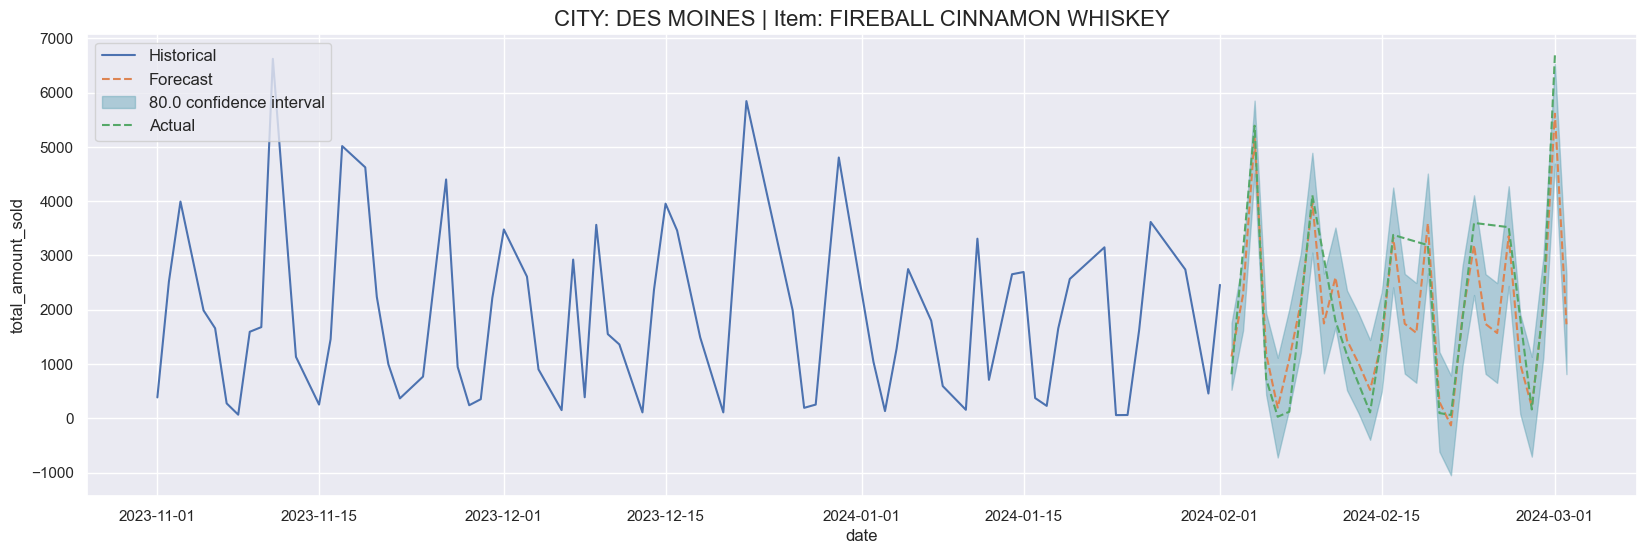

In [113]:
train_data_query = f"""
SELECT *
FROM `bqmlforecast.training_data`
WHERE
    item_name = '{item_name}'
    AND city = '{city}'
ORDER BY
    city, item_name, date
"""
train_data_query_job = client.query(train_data_query)
train_df = train_data_query_job.to_dataframe()

plot_historical_and_forecast(
    input_timeseries=train_df.sort_values("date"),
    timestamp_col_name="date",
    data_col_name="total_amount_sold",
    forecast_output=pred_xreg_df.rename(
        columns={
            "date": "forecast_timestamp",
            "prediction_interval_lower_bound": "confidence_interval_lower_bound",
            "prediction_interval_upper_bound": "confidence_interval_upper_bound",
        }
    ).sort_values("forecast_timestamp"),
    actual=actual_df.sort_values("date"),
    title=f"CITY: {city} | Item: {item_name}",
    plotstartdate="2023-11-01",
    prop={'size': 12},
)

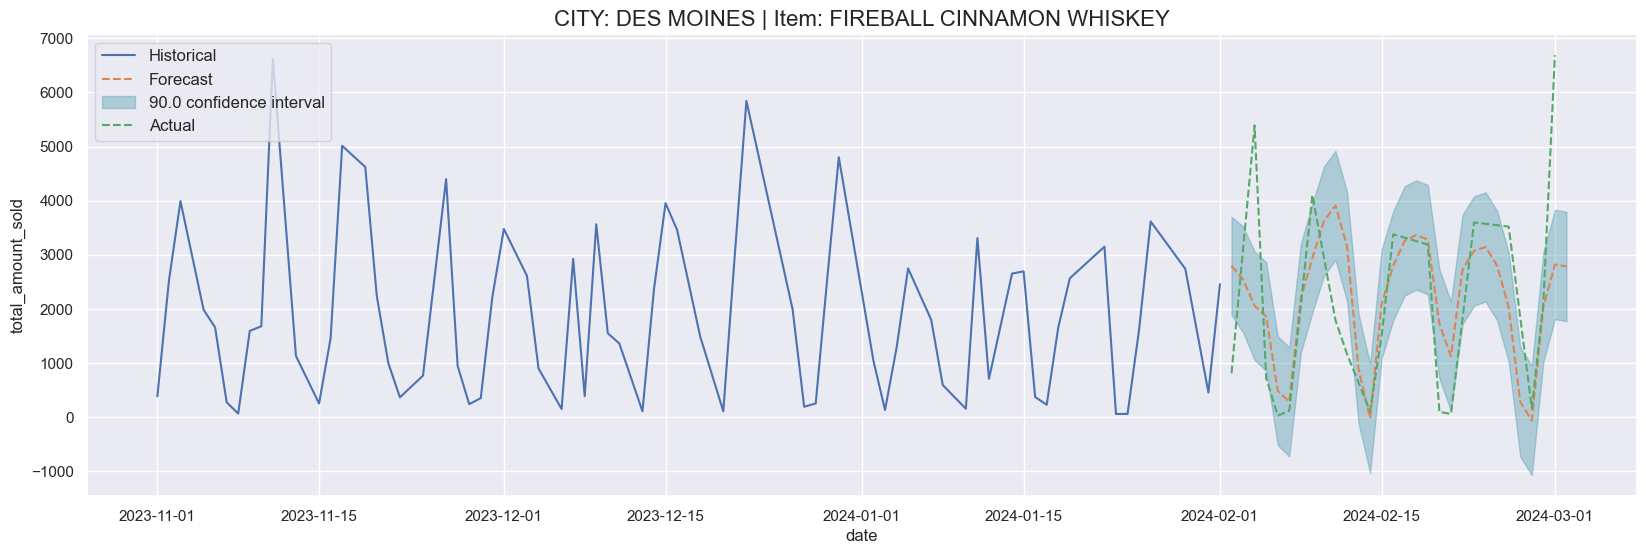

In [117]:
predictions_df

plot_historical_and_forecast(
    input_timeseries=train_df.sort_values("date"),
    timestamp_col_name="date",
    data_col_name="total_amount_sold",
    forecast_output=predictions_df.rename(
        columns={
            "date": "forecast_timestamp",
            # "prediction_interval_lower_bound": "confidence_interval_lower_bound",
            # "prediction_interval_upper_bound": "confidence_interval_upper_bound",
        }
    ).sort_values("forecast_timestamp"),
    actual=actual_df.sort_values("date"),
    title=f"CITY: {city} | Item: {item_name}",
    plotstartdate="2023-11-01",
    prop={'size': 12},
)

In [40]:
import seaborn as sns
sns.set_theme()

In [ ]:
itemslist = list(df_train.item_name.unique())

for item in itemslist:
    datah = df_train[df_train.item_name==item].sort_values('date')
    dataf = predictions_df[predictions_df.item_name==item].sort_values(['forecast_timestamp'])
    dataa = actual_df[actual_df.item_name==item].sort_values('date')

    plot_historical_and_forecast(
        input_timeseries=datah,
        timestamp_col_name="date",
        data_col_name="total_amount_sold",
        forecast_output=dataf,
        actual=dataa,
        title=item,
        plotstartdate="2023-11-01",
        prop={'size': 12},
    )

In [52]:
%%bigquery --params {"TRAININGDATA_STARTDATE": '2023-01-01', "TRAININGDATA_ENDDATE": '2024-01-01'}  --project "bunge-demo"

CREATE OR REPLACE VIEW bqmlforecast.outputdata_datastudio AS (
  SELECT
    date AS timestamp,
    item_name,
    total_amount_sold AS history_value,
    NULL AS forecast_value,
    NULL AS prediction_interval_lower_bound,
    NULL AS prediction_interval_upper_bound
  FROM
    bqmlforecast.training_data
  UNION ALL
  SELECT
    EXTRACT(DATE
    FROM
      forecast_timestamp) AS timestamp,
    item_name,
    NULL AS history_value,
    forecast_value,
    prediction_interval_lower_bound,
    prediction_interval_upper_bound
  FROM
    ML.FORECAST(MODEL bqmlforecast.arima_model,
      STRUCT(30 AS horizon, 0.9 AS confidence_level)) 
  ORDER BY timestamp
  )

Query is running:   0%|          |

Empty DataFrame
Columns: []
Index: []

In [45]:
actual_job.to_dataframe()

In [54]:
x = training_data_table_creation_job.to_dataframe()

In [56]:
x.empty

True

In [58]:
x.columns.empty

True